# Step Detection using SVM on NURVV Trackers

This notebook reports the entire journey from performing Exploratory Data Analysis (EDA) on the IMU samples, to the signal processing used to label data, and to finally applying Support Vector Machine (SVM) to classify the samples of a model into step or no-step.

In [19]:
# Import libraries
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import time
from scipy.optimize import curve_fit
import pylab
from sklearn import preprocessing
import pickle
import matplotlib

%matplotlib inline

In [20]:
# The following variables will allow to set the figures in a way that they can be read in the article
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGISH_SIZE = 20
BIGGER_SIZE = 30

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

# Resets matplotlib style configuration. Uncomment this line if you want previous configurations being applied.
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

## Process a Nurvv Dataset

In [61]:
data_folder = '2019-07-23_CricketPitch_Josh'

In [62]:
# Extract IMU (accelerometer + gyroscope) from the data folder provided

# Read accelerometer csv file, and calibrate data based on sensor datasheet
df_acc = pd.read_csv(data_folder + '/imu_acc.csv') 
df_acc['Accel-X'] = df_acc['Accel-X'].multiply(9.80665)
df_acc['Accel-Y'] = df_acc['Accel-Y'].multiply(9.80665)
df_acc['Accel-Z'] = df_acc['Accel-Z'].multiply(9.80665)

# Read gyro csv file, and calibrate data based on sensor datasheet
df_gyro = pd.read_csv(data_folder + '/imu_gyro.csv') 
df_gyro['Gyro-X'] = df_gyro['Gyro-X'].multiply(0.017453)
df_gyro['Gyro-Y'] = df_gyro['Gyro-Y'].multiply(0.017453)
df_gyro['Gyro-Z'] = df_gyro['Gyro-Z'].multiply(0.017453)

df_gyro.tail()

TimeStamp    Gyro-X    Gyro-Y    Gyro-Z
237338  1773908900 -0.087265 -0.055339  0.012770
237339  1773909779 -0.089393 -0.061724  0.006385
237340  1773910657 -0.093650 -0.065981  0.008514
237341  1773911536 -0.093650 -0.065981  0.002128
237342  1773912415 -0.095779 -0.070238  0.002128

In [63]:
# Aggregate IMU data into a single dataframe
data_imu = [(df_acc['TimeStamp'].values - df_acc['TimeStamp'].values[0])/1_000,
            df_acc['Accel-X'].values, 
            df_acc['Accel-Y'].values, 
            df_acc['Accel-Z'].values, 
            df_gyro['Gyro-X'].values, 
            df_gyro['Gyro-Y'].values, 
            df_gyro['Gyro-Z'].values]

df_imu = pd.DataFrame(data_imu)
df_imu = df_imu.T
df_imu.columns = ['Timestamp', 'Accel-X', 'Accel-Y', 'Accel-Z', 'Gyro-X', 'Gyro-Y', 'Gyro-Z']
df_imu = df_imu.set_index('Timestamp')
df_imu.head()

Accel-X   Accel-Y   Accel-Z    Gyro-X    Gyro-Y    Gyro-Z
Timestamp                                                            
0.000      9.768345  0.383067  0.402230 -0.087265 -0.068109  0.000000
0.879      9.797069  0.383067  0.392648 -0.091522 -0.068109  0.000000
1.758      9.825802  0.383067  0.344763 -0.087265 -0.070238  0.002128
2.637      9.835383  0.344763  0.344763 -0.091522 -0.070238 -0.004257
3.515      9.844955  0.354344  0.392648 -0.095779 -0.072366 -0.006385

## Exploratory Data Analysis

In [64]:
print("Initial Timestamp: " + str(df_imu.index[0]/1_000) + "s")
print("Final Timestamp: " + str(df_imu.index[-1]/1_000) + "s")

# Have a look at the head of the dataframe
df_imu.head()

Initial Timestamp: 0.0s
Final Timestamp: 208.565482s


Accel-X   Accel-Y   Accel-Z    Gyro-X    Gyro-Y    Gyro-Z
Timestamp                                                            
0.000      9.768345  0.383067  0.402230 -0.087265 -0.068109  0.000000
0.879      9.797069  0.383067  0.392648 -0.091522 -0.068109  0.000000
1.758      9.825802  0.383067  0.344763 -0.087265 -0.070238  0.002128
2.637      9.835383  0.344763  0.344763 -0.091522 -0.070238 -0.004257
3.515      9.844955  0.354344  0.392648 -0.095779 -0.072366 -0.006385

In [65]:
# Some quick stats on the IMU data
df_imu.describe()

Accel-X        Accel-Y        Accel-Z         Gyro-X  \
count  237343.000000  237343.000000  237343.000000  237343.000000   
mean       22.836629      -6.707917      -1.332425      -0.003322   
std        22.826558      30.313751      24.490153       3.486748   
min      -135.521391    -187.341495    -214.233163     -16.250446   
25%         9.787498     -13.503296     -11.032481      -1.938986   
50%        22.572535       0.555458      -2.030281      -0.338418   
75%        35.003229       9.940727       4.903325       1.213196   
max       292.561868     194.926321     303.000586      30.670455   

              Gyro-Y         Gyro-Z  
count  237343.000000  237343.000000  
mean       -0.280723      -0.036863  
std         4.718201       6.607989  
min       -26.637109     -15.645976  
25%        -3.341611      -6.964173  
50%        -0.148989       1.111032  
75%         1.594183       4.997518  
max        43.655913      13.196171

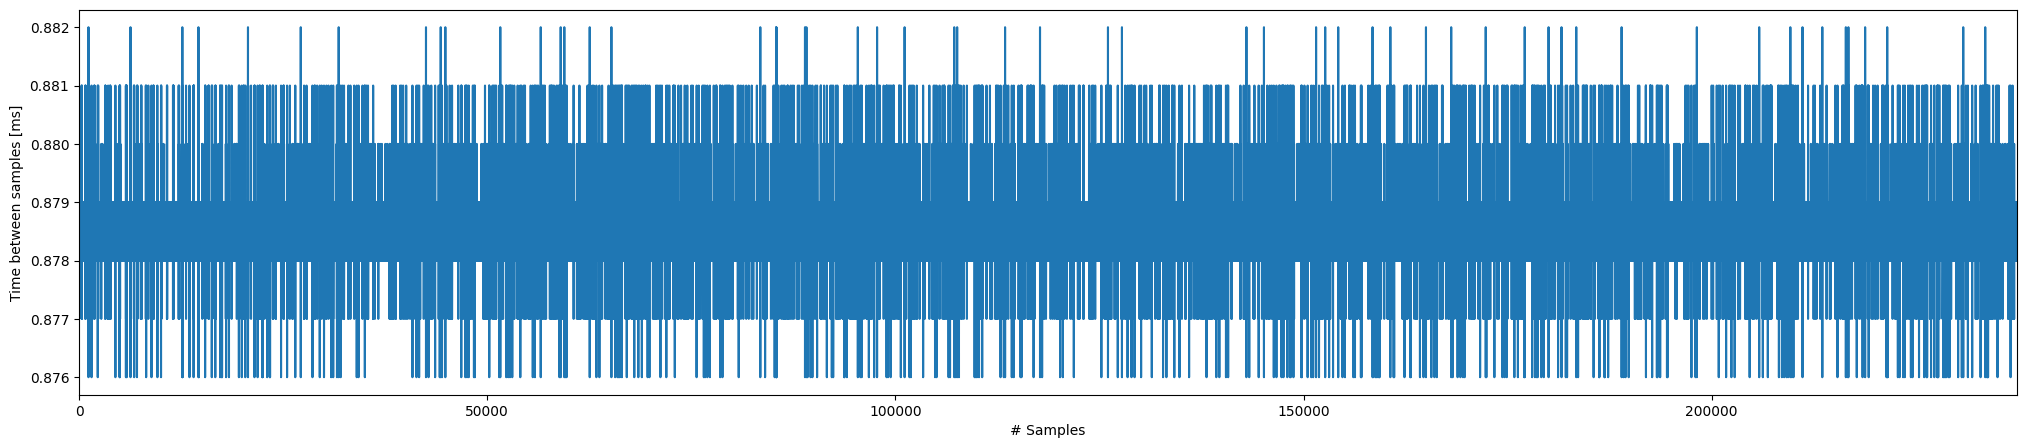

In [66]:
# Check if distance between IMU samples are approximately identical
plt.figure(figsize=(25,5))
plt.plot(np.diff(df_imu.index))
plt.xlim(0, len(np.diff(df_imu.index)))
plt.xlabel('# Samples')
plt.ylabel('Time between samples [ms]')
plt.show()

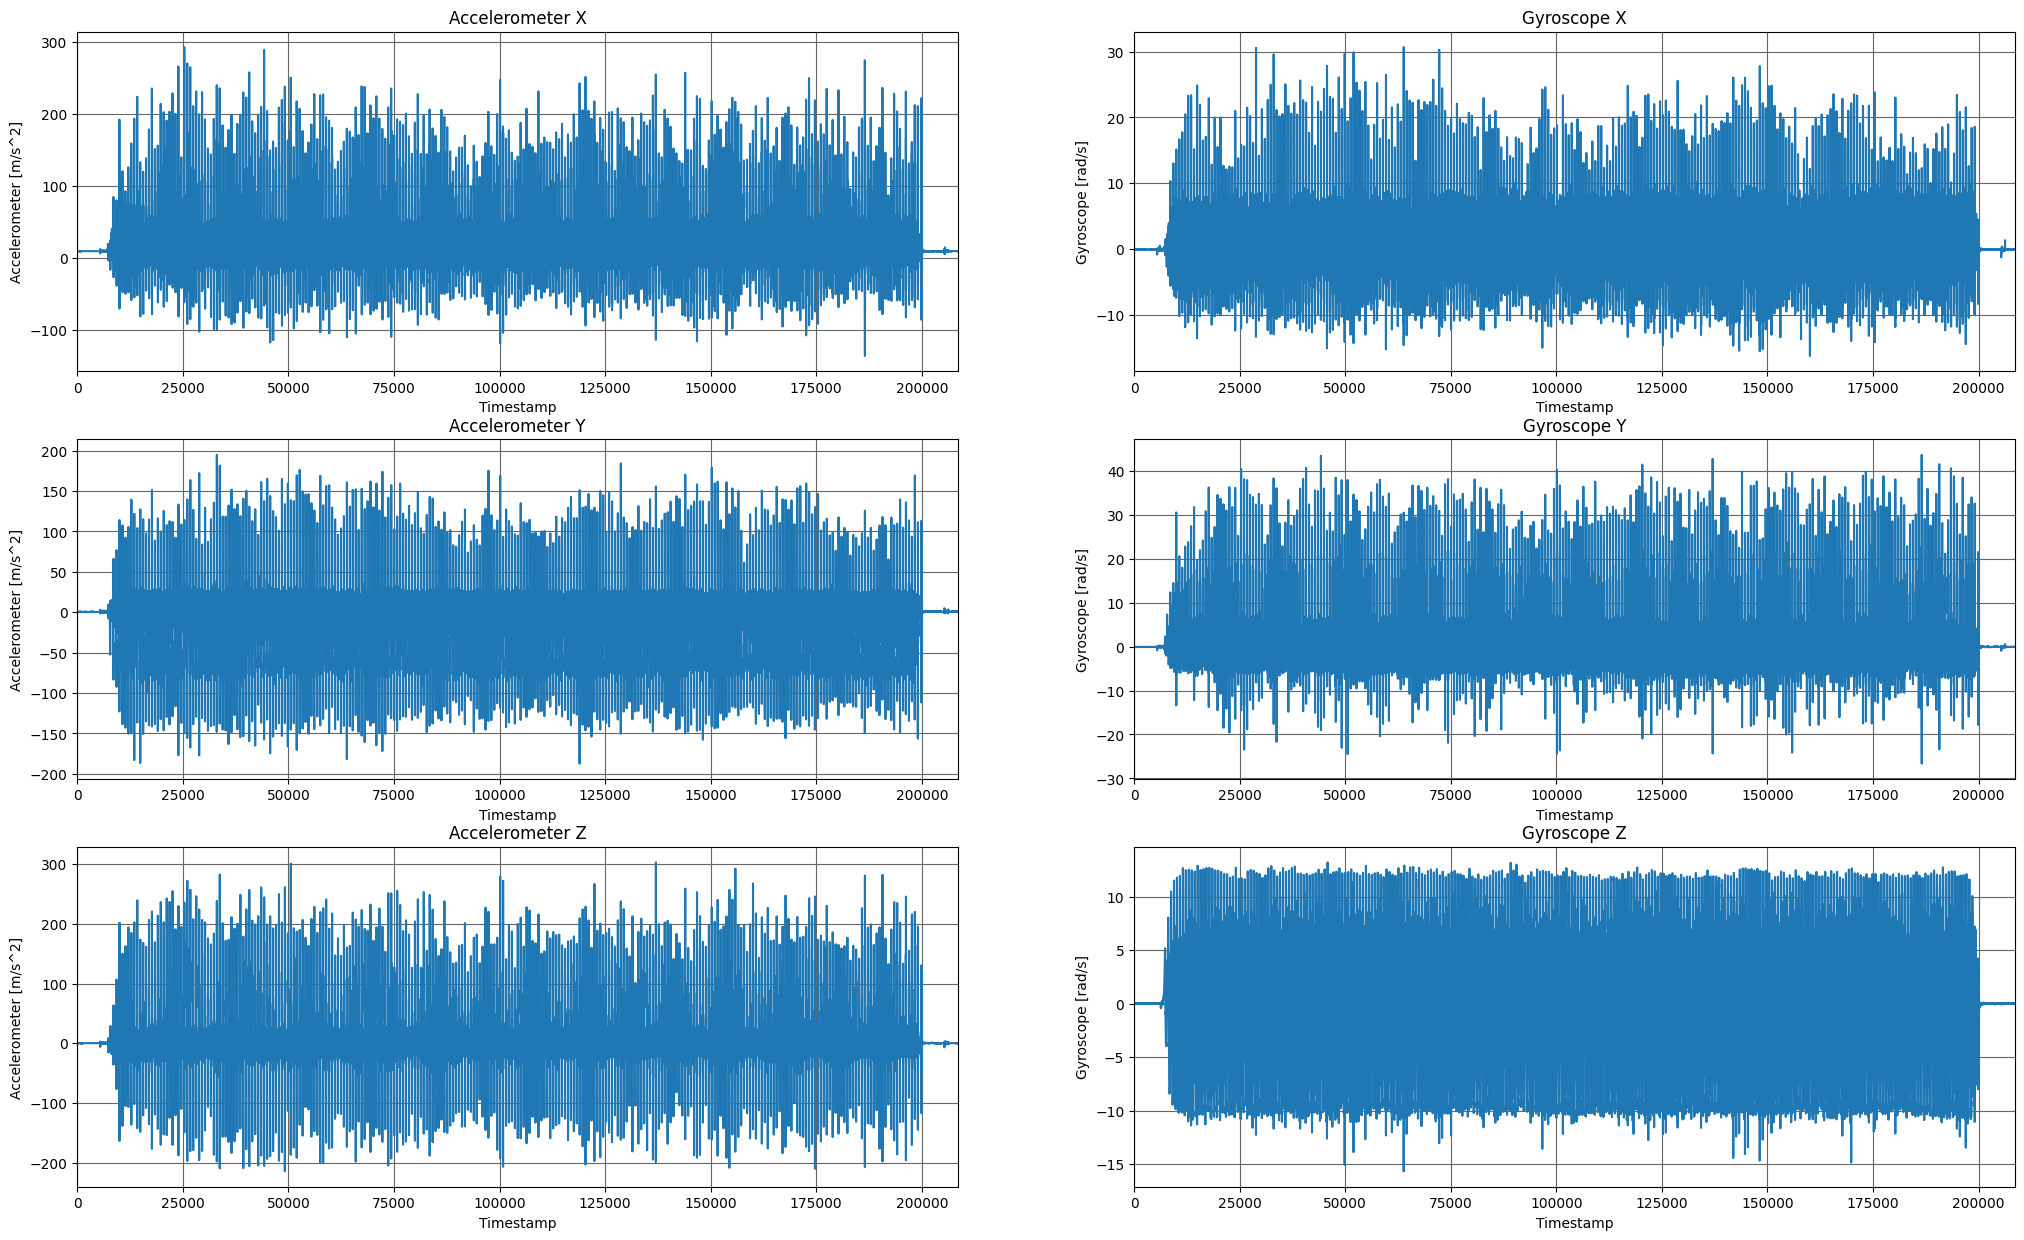

In [67]:
# Check entire IMU data to see if we should crop it to consider only running period
plt.figure(figsize=(25,15))

plt.subplot(321)
plt.title(f"Accelerometer X")
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Accel-X'])
plt.xlim(df_imu.index[0], df_imu.index[-1])

plt.subplot(323)
plt.title(f"Accelerometer Y")
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Accel-Y'])
plt.xlim(df_imu.index[0], df_imu.index[-1])

plt.subplot(325)
plt.title(f"Accelerometer Z")
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Accel-Z'])
plt.xlim(df_imu.index[0], df_imu.index[-1])

plt.subplot(322)
plt.title(f"Gyroscope X")
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Gyro-X'])
plt.xlim(df_imu.index[0], df_imu.index[-1])

plt.subplot(324)
plt.title(f"Gyroscope Y")
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Gyro-Y'])
plt.xlim(df_imu.index[0], df_imu.index[-1])

plt.subplot(326)
plt.title(f"Gyroscope Z")
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Gyro-Z'])
plt.xlim(df_imu.index[0], df_imu.index[-1])

plt.show()

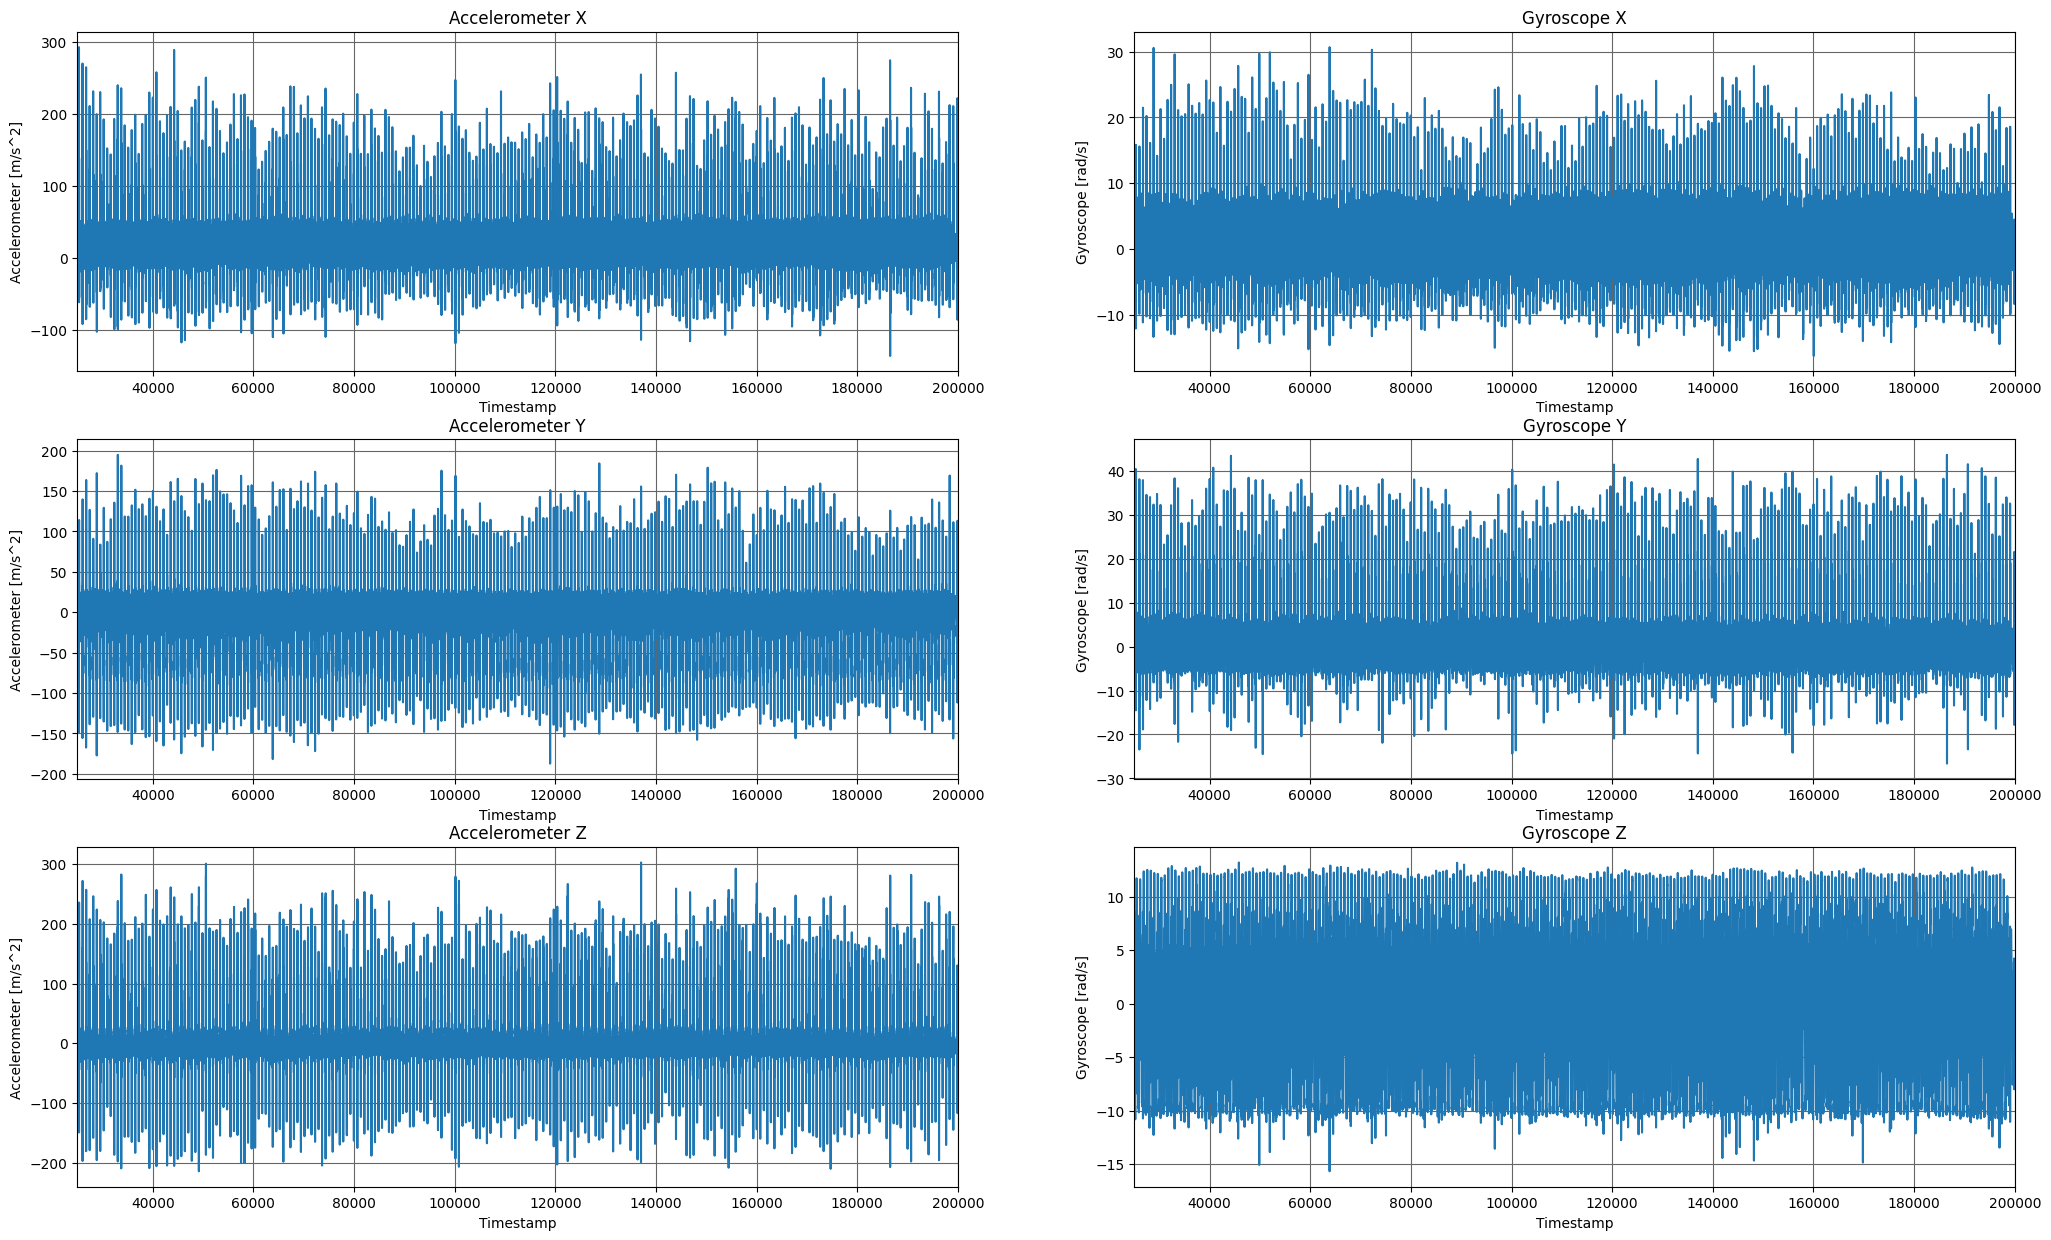

In [68]:
# Crop IMU data to running period
if data_folder == '2019-07-23_CricketPitch_Grant':
    initial_timestamp_to_crop = 25000
    final_timestamp_to_crop = 200000
elif data_folder == '2019-07-23_CricketPitch_Josh':
    initial_timestamp_to_crop = 25000
    final_timestamp_to_crop = 200000
elif data_folder == '2018-04-25_FenMichael':
    initial_timestamp_to_crop = 65000
    final_timestamp_to_crop = 100000
elif data_folder == 'Run Data/2018-05-09_ITLcombo/run_01':
    initial_timestamp_to_crop = 50000
    final_timestamp_to_crop = 200000
else:
    initial_timestamp_to_crop = 75000
    final_timestamp_to_crop = 150000

plt.figure(figsize=(25,15))

plt.subplot(321)
plt.title(f"Accelerometer X")
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Accel-X'])
plt.xlim(initial_timestamp_to_crop, final_timestamp_to_crop)

plt.subplot(323)
plt.title(f"Accelerometer Y")
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Accel-Y'])
plt.xlim(initial_timestamp_to_crop, final_timestamp_to_crop)

plt.subplot(325)
plt.title(f"Accelerometer Z")
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Accel-Z'])
plt.xlim(initial_timestamp_to_crop, final_timestamp_to_crop)

plt.subplot(322)
plt.title(f"Gyroscope X")
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Gyro-X'])
plt.xlim(initial_timestamp_to_crop, final_timestamp_to_crop)

plt.subplot(324)
plt.title(f"Gyroscope Y")
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Gyro-Y'])
plt.xlim(initial_timestamp_to_crop, final_timestamp_to_crop)

plt.subplot(326)
plt.title(f"Gyroscope Z")
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Gyro-Z'])
plt.xlim(initial_timestamp_to_crop, final_timestamp_to_crop)

plt.show()

In [69]:
# When happy about the cropping run this command.
df_imu = df_imu[(df_imu.index > initial_timestamp_to_crop) & (df_imu.index < final_timestamp_to_crop)]

# CAREFUL! 
# This will make the timestamp start at 0, but if this cell is run a second time the line above will change our df
#df_imu.index -= df_imu.index[0]

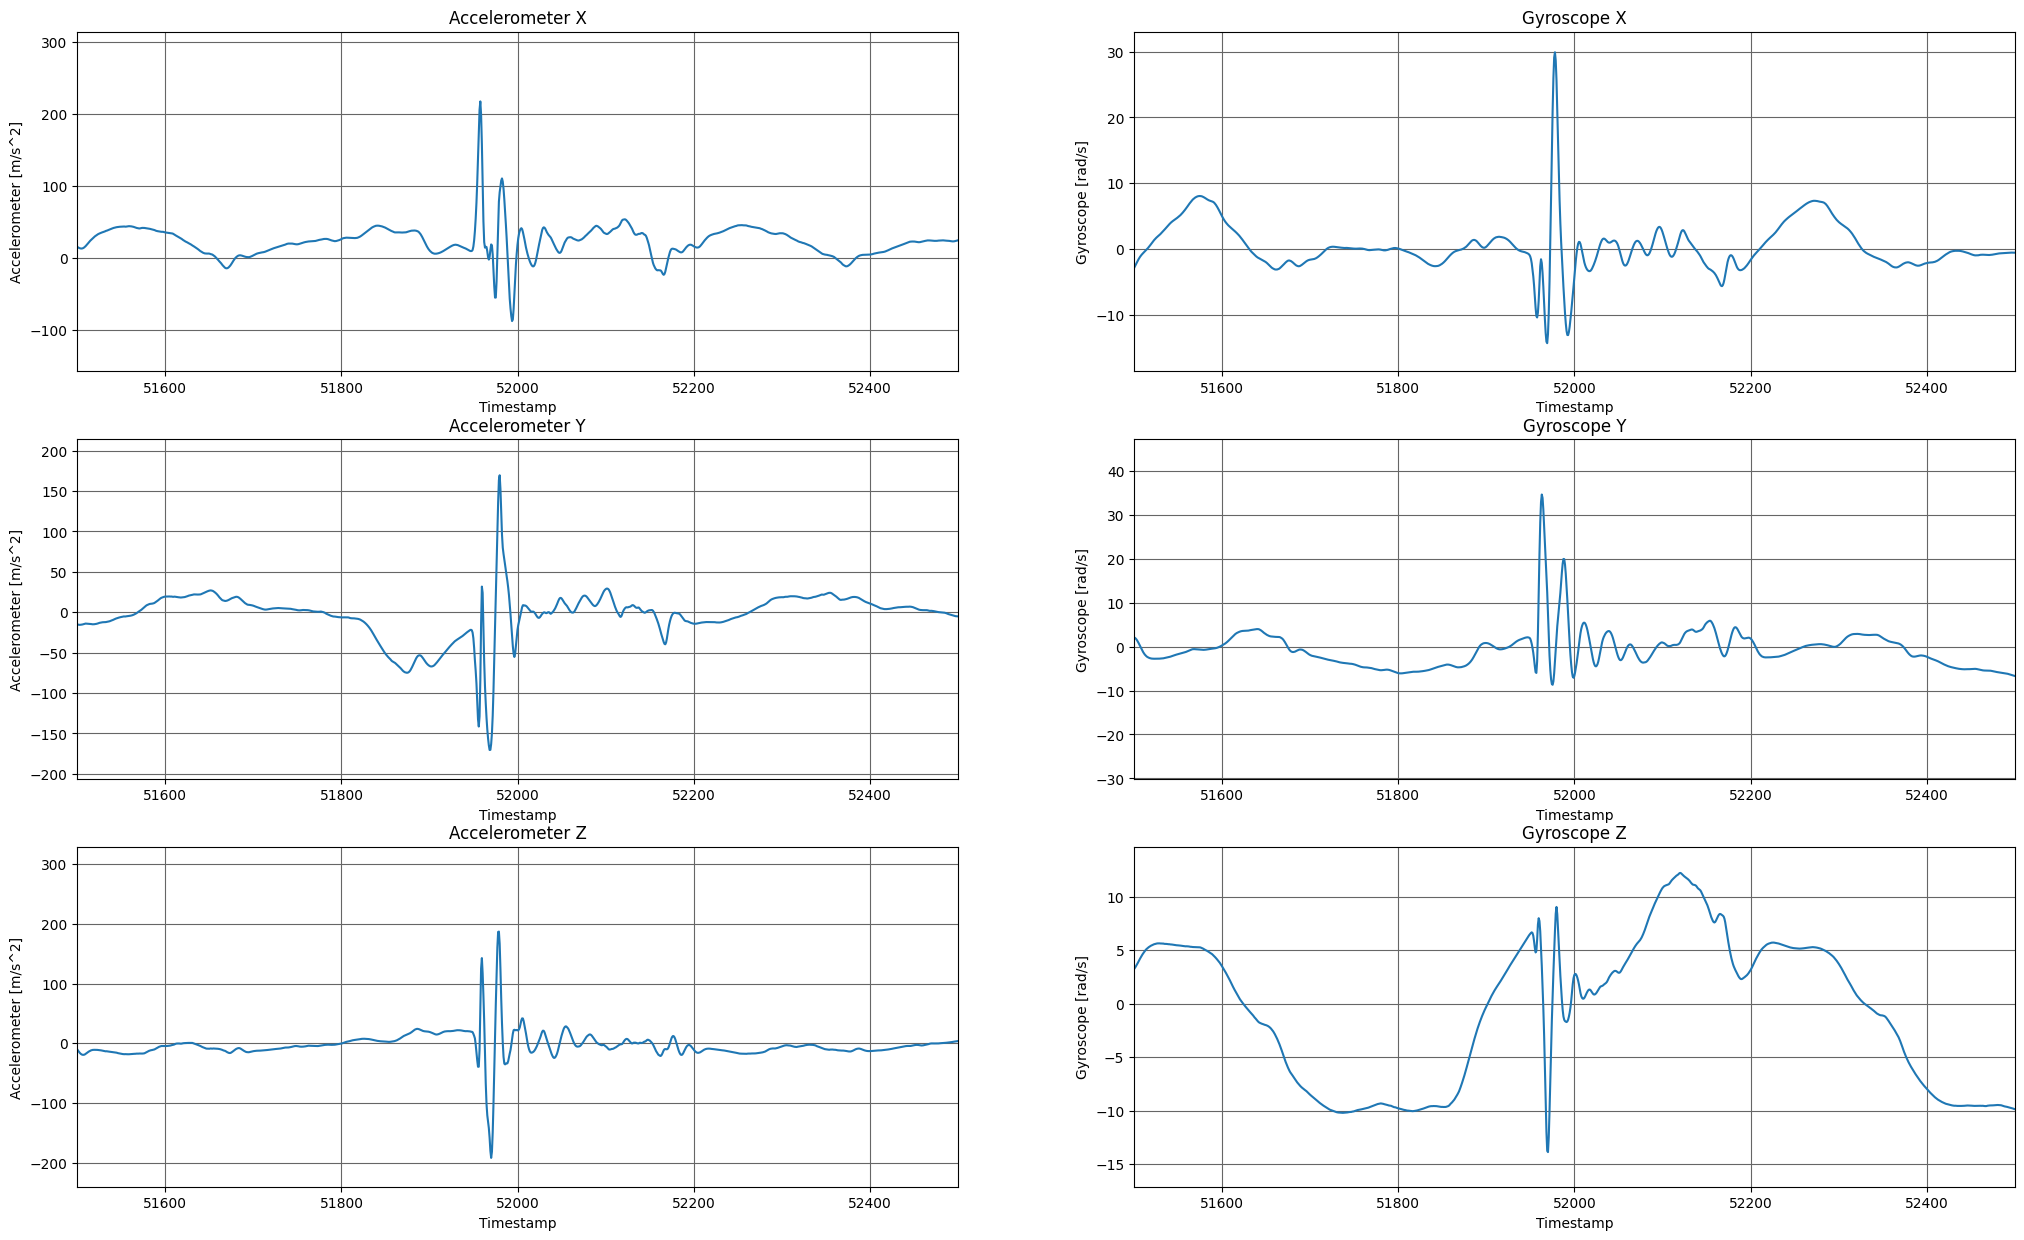

In [70]:
# Inspect IMU data at Footstrike
initial_timestamp_to_inspect = 51500
final_timestamp_to_inspect = 52500

plt.figure(figsize=(25,15))

plt.subplot(321)
plt.title(f"Accelerometer X")
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Accel-X'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)

plt.subplot(323)
plt.title(f"Accelerometer Y")
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Accel-Y'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)

plt.subplot(325)
plt.title(f"Accelerometer Z")
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Accel-Z'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)

plt.subplot(322)
plt.title(f"Gyroscope X")
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Gyro-X'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)

plt.subplot(324)
plt.title(f"Gyroscope Y")
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Gyro-Y'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)

plt.subplot(326)
plt.title(f"Gyroscope Z")
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp')
plt.plot(df_imu.index, df_imu['Gyro-Z'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)

plt.show()

In [71]:
# When happy with result above, slice this data accordingly
df_inspect_imu = df_imu[(df_imu.index > initial_timestamp_to_inspect) & (df_imu.index < final_timestamp_to_inspect)]

From the IMU data as a function of time we can tell when the footstrike happened, however this is not based on the magnitude of the components of the gyro/acc samples individually. This is from the fact that visually we see a big oscillation when such event happens. I.e. we can have a value of Acceleration 0 and a footstrike just happened, and the reason for this is because it's oscillating from a large magnitude negative to positive, or vice-versa.

This theory is corroborated by the fact that if we plot a histogram of the data we won't see 2 clear cuts of the data. See plot below.

Note: Although we probably can develop a good algorithm based purely on the nominal IMU values. This won't generalize well for different runners with different running style, with different shoes (will change axis of IMU based on position), running on different terrains.... Therefore, it's important to be "axis-agnostic". I.e. remove the dependency of the axis.

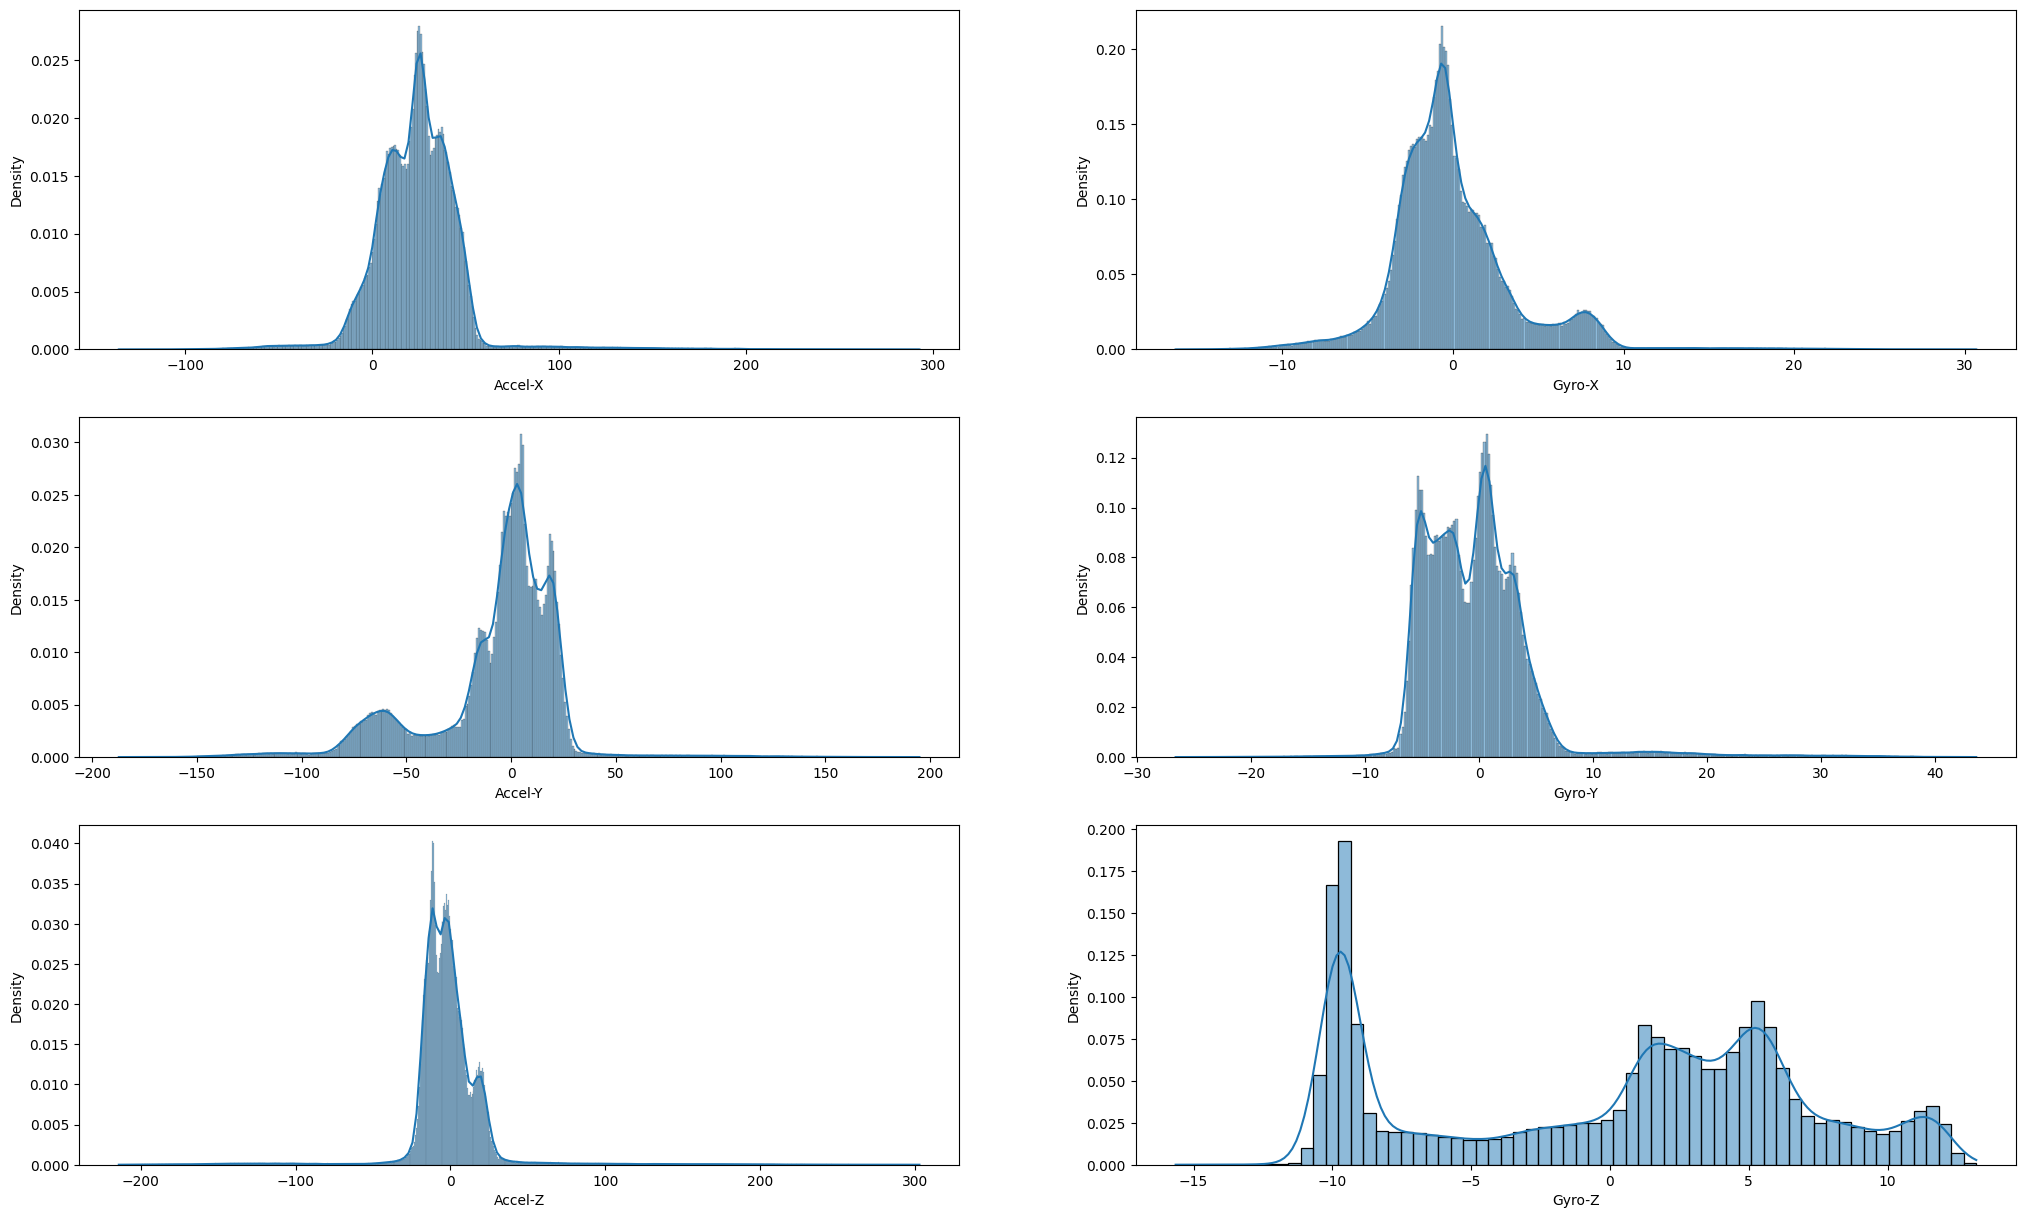

In [72]:
plt.figure(figsize=(25, 15))
plt.subplot(321)
sns.histplot(data=df_imu, x="Accel-X", kde=True, stat="density")
plt.subplot(323)
sns.histplot(data=df_imu, x="Accel-Y", kde=True, stat="density")
plt.subplot(325)
sns.histplot(data=df_imu, x="Accel-Z", kde=True, stat="density")
plt.subplot(322)
sns.histplot(data=df_imu, x="Gyro-X", kde=True, stat="density")
plt.subplot(324)
sns.histplot(data=df_imu, x="Gyro-Y", kde=True, stat="density")
plt.subplot(326)
sns.histplot(data=df_imu, x="Gyro-Z", kde=True, stat="density")

plt.show()

In order to start the process of being axis-agnostic, let's consider the Accelerometer and Gyroscope data by it's magnitude. 

## PCA to understand sensor data

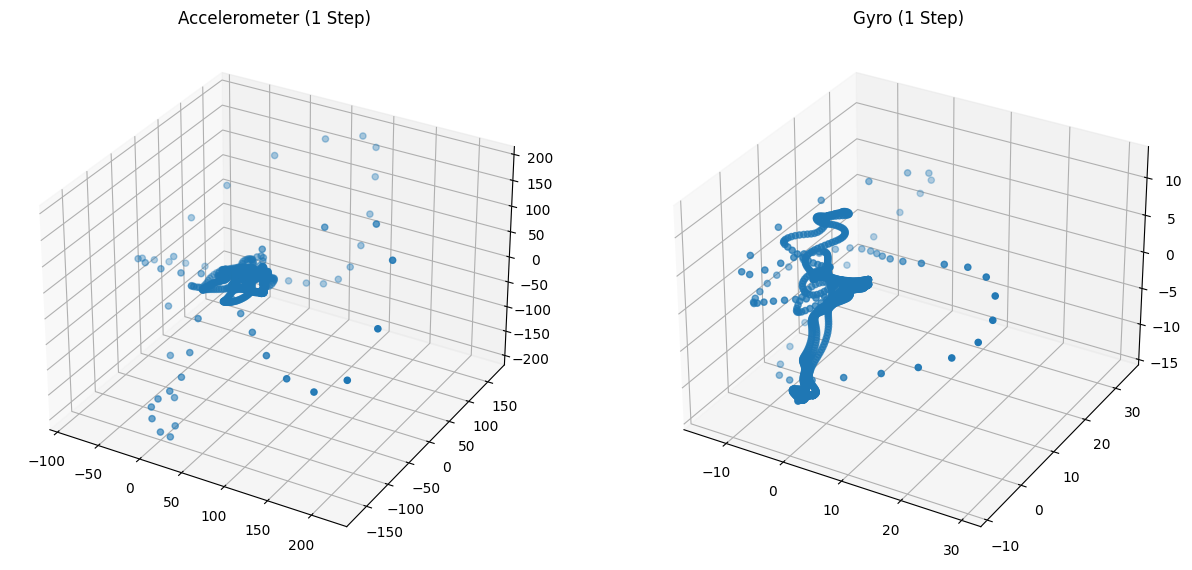

In [73]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(121,projection='3d')
plt.title('Accelerometer (1 Step)')
ax1.scatter3D(df_inspect_imu['Accel-X'], df_inspect_imu['Accel-Y'], df_inspect_imu['Accel-Z'], cmap='Greens');

ax2 = fig.add_subplot(122,projection='3d')
plt.title('Gyro (1 Step)')
ax2.scatter3D(df_inspect_imu['Gyro-X'], df_inspect_imu['Gyro-Y'], df_inspect_imu['Gyro-Z'], cmap='Greens');

plt.show()

Due to the "clear line" on the center for both GYRO and ACC data, and the sparsed samples on the outside. It's fairly intuitive to assume that these "outdoor data" corresponds to a footstrike event.

HOWEVER, some samples of these outdoor data turn around in the center, hence, making their distinction difficult. This shouldn't be a problem if we use a signal processing technique, where we don't rely on a sample by itself, but on the previous ones to identify if that sample on the inside is part of a footstrike being detected.

Also, this is good news, as by looking at the left plot, using an SVM with a non-linear kernel, this seems like an easy classification problem.

Nonetheless, let us apply PCA, as it's easier to understand data in 2 dimensions

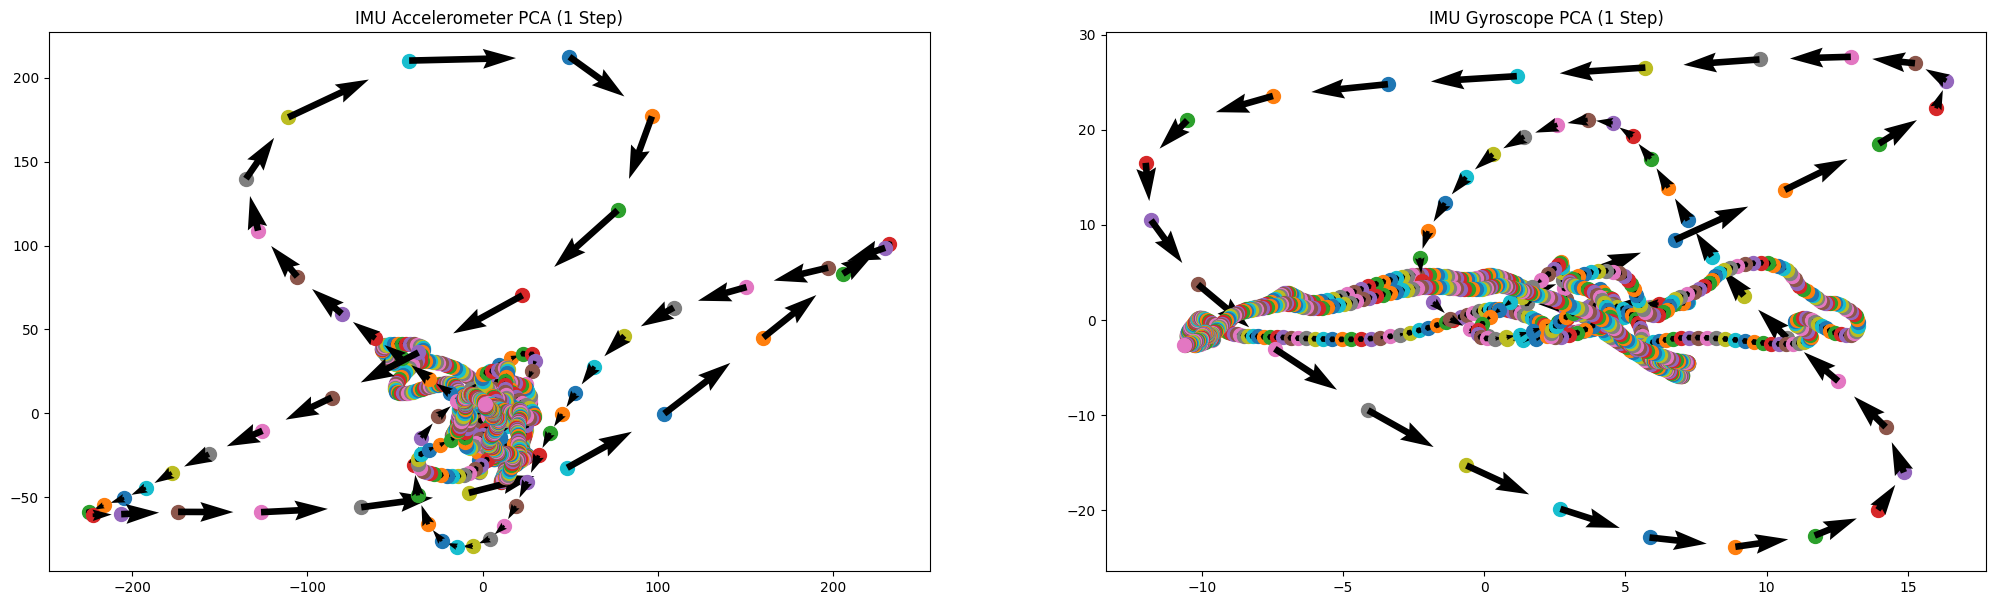

In [74]:
fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(121)
plt.title('IMU Accelerometer PCA (1 Step)')
pca = PCA(n_components=2)
IMU = pca.fit(df_inspect_imu[['Accel-X', 'Accel-Y', 'Accel-Z']]).transform(df_inspect_imu[['Accel-X', 'Accel-Y', 'Accel-Z']])
for i in range(len(IMU)-1):
    ax1.quiver(IMU[i][0], IMU[i][1], IMU[i+1][0]-IMU[i][0], IMU[i+1][1]-IMU[i][1], angles='xy', scale_units='xy', scale=1.5)
    ax1.scatter(IMU[i+1][0], IMU[i+1][1], s=100)
    
ax2 = fig.add_subplot(122)
plt.title('IMU Gyroscope PCA (1 Step)')
pca = PCA(n_components=2)
IMU = pca.fit(df_inspect_imu[['Gyro-X', 'Gyro-Y', 'Gyro-Z']]).transform(df_inspect_imu[['Gyro-X', 'Gyro-Y', 'Gyro-Z']])
for i in range(len(IMU)-1):
    ax2.quiver(IMU[i][0], IMU[i][1], IMU[i+1][0]-IMU[i][0], IMU[i+1][1]-IMU[i][1], angles='xy', scale_units='xy', scale=1.5)
    ax2.scatter(IMU[i+1][0], IMU[i+1][1], s=100)

plt.show()

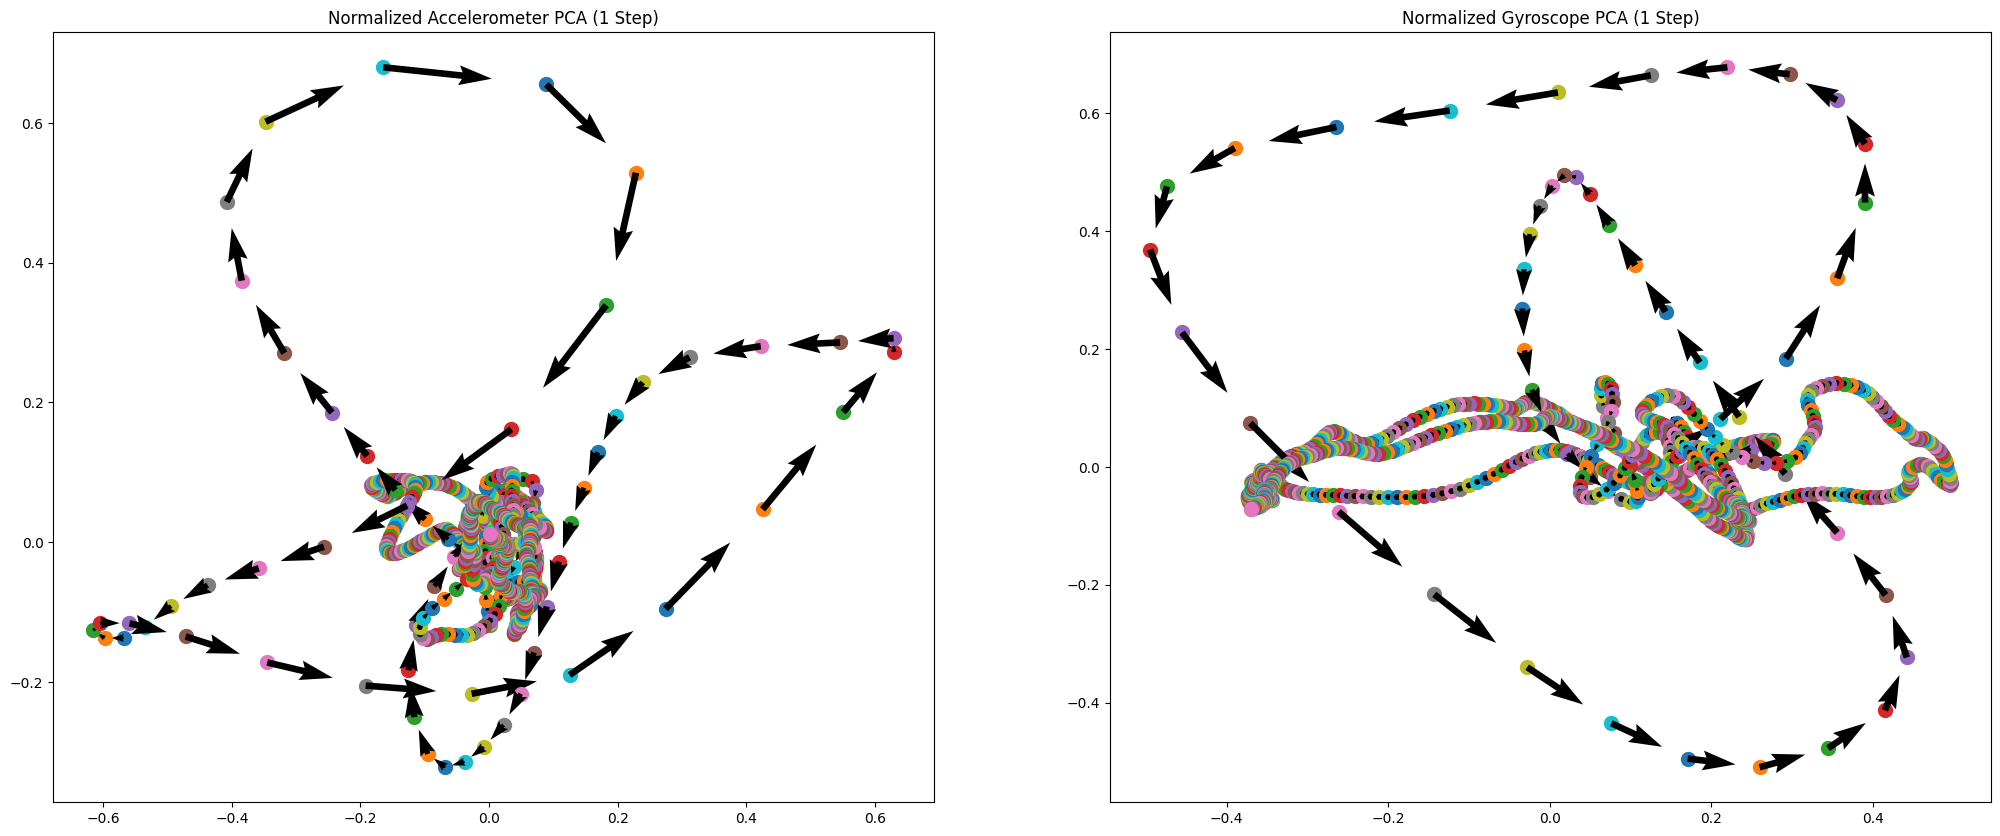

In [75]:
fig = plt.figure(figsize=(25,10))
ax1 = fig.add_subplot(121)
plt.title('Normalized Accelerometer PCA (1 Step)')
pca = PCA(n_components=2)
min_max_scaler = preprocessing.MinMaxScaler()
acc_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_inspect_imu[['Accel-X', 'Accel-Y', 'Accel-Z']]))
IMU = pca.fit(acc_scaled).transform(acc_scaled)
for i in range(len(IMU)-1):
    ax1.quiver(IMU[i][0], IMU[i][1], IMU[i+1][0]-IMU[i][0], IMU[i+1][1]-IMU[i][1], angles='xy', scale_units='xy', scale=1.5)
    ax1.scatter(IMU[i+1][0], IMU[i+1][1], s=100)
    
ax2 = fig.add_subplot(122)
plt.title('Normalized Gyroscope PCA (1 Step)')
pca = PCA(n_components=2)
min_max_scaler = preprocessing.MinMaxScaler()
gyro_scaled = pd.DataFrame(min_max_scaler.fit_transform(df_inspect_imu[['Gyro-X', 'Gyro-Y', 'Gyro-Z']]))
IMU = pca.fit(gyro_scaled).transform(gyro_scaled)
for i in range(len(IMU)-1):
    ax2.quiver(IMU[i][0], IMU[i][1], IMU[i+1][0]-IMU[i][0], IMU[i+1][1]-IMU[i][1], angles='xy', scale_units='xy', scale=1.5)
    ax2.scatter(IMU[i+1][0], IMU[i+1][1], s=100)

plt.show()

## Signal Processing - For Data labelling

In addition to the magnitude, we saw that the distance between points gets larger when a footstrike happens, the reason for this is because of the IMU inherent oscillations with the impact. 

So, let's assess this derivative (distance between 2 consecutive samples).

As you'll see below, after doing the derivative we'll have negative and positive values. This is expected because the magnitude is not monotonic. Hence, we can apply the absolute function, since we don't care about the sign, and want to get as close as possible from a clear cut between step and no step.

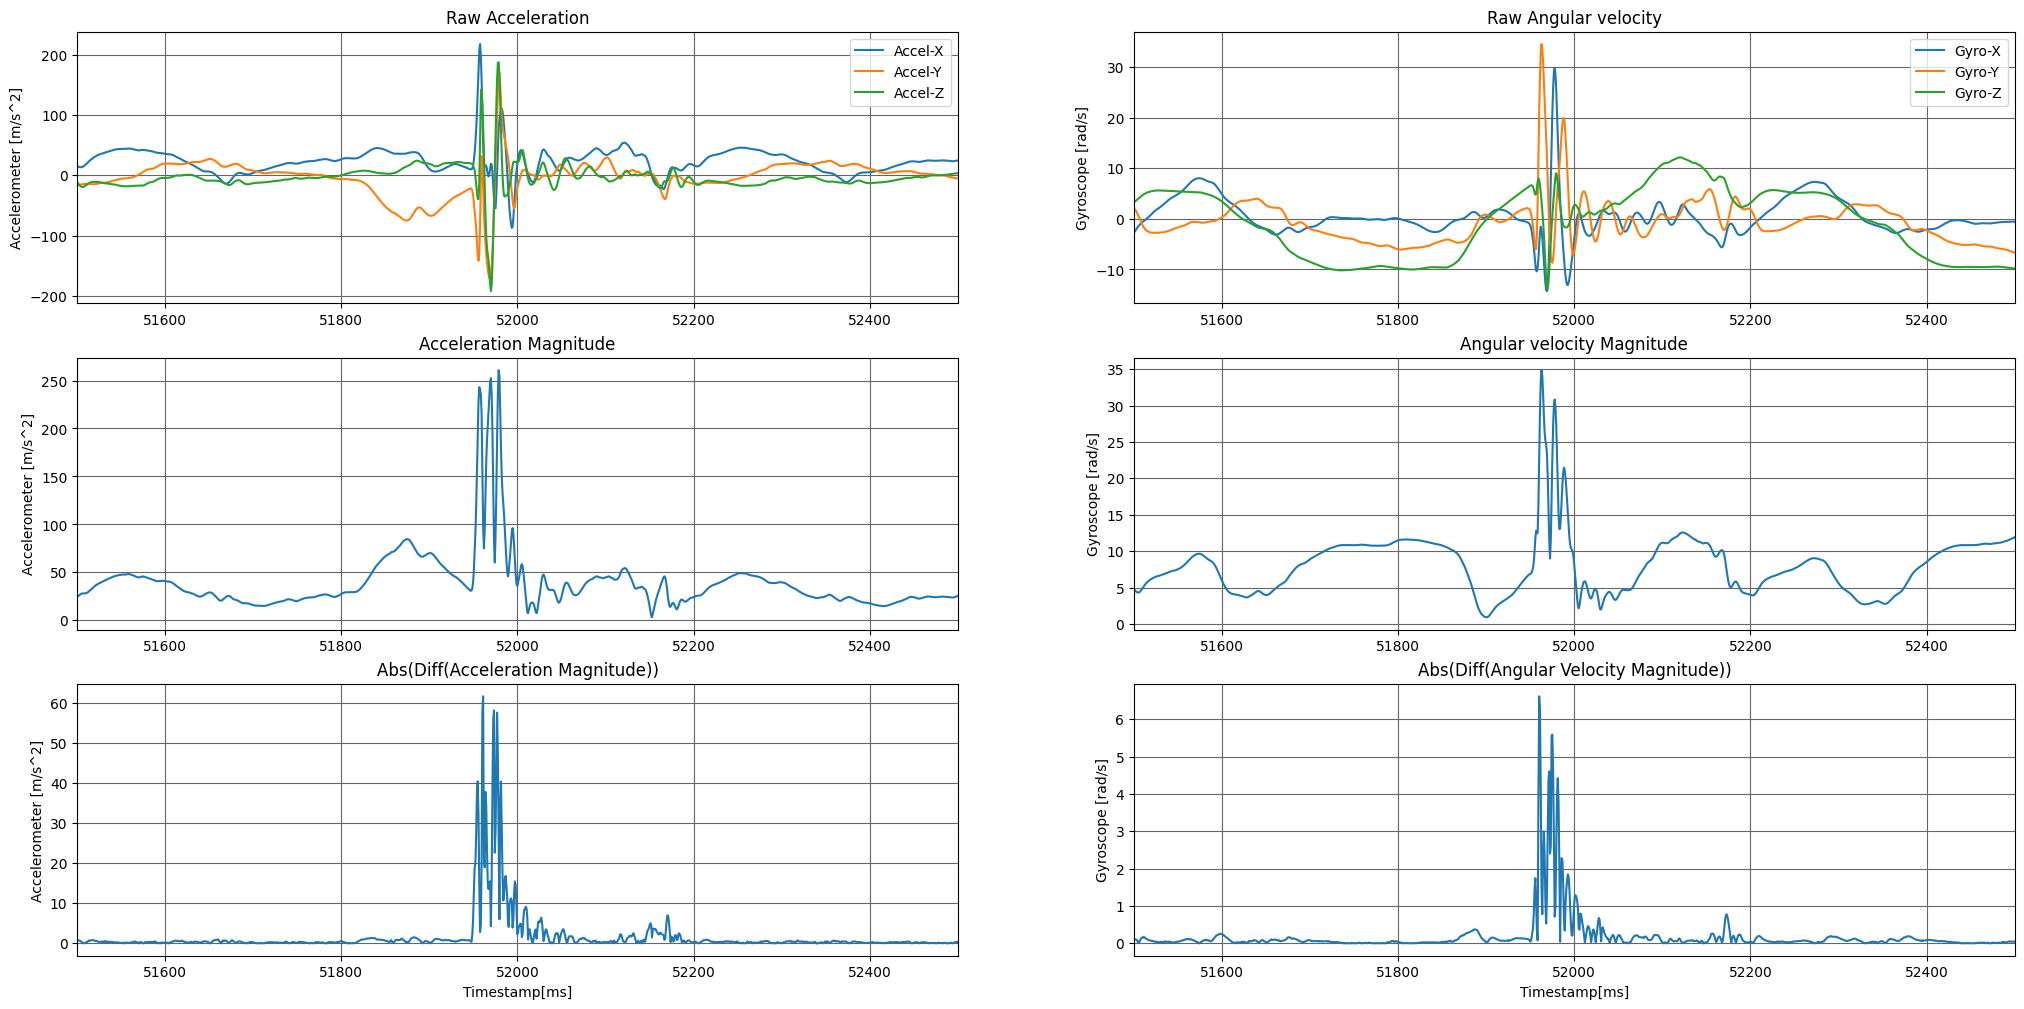

In [93]:
plt.figure(figsize=(25,12))

plt.subplot(321)
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.title('Raw Acceleration')
plt.plot(df_inspect_imu.index, df_inspect_imu['Accel-X'])
plt.plot(df_inspect_imu.index, df_inspect_imu['Accel-Y'])
plt.plot(df_inspect_imu.index, df_inspect_imu['Accel-Z'])
plt.legend(['Accel-X', 'Accel-Y', 'Accel-Z'])
plt.xlim(df_inspect_imu.index[0], df_inspect_imu.index[-1])

plt.subplot(323)
plt.title('Acceleration Magnitude')
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df_inspect_imu.index, np.sqrt(df_inspect_imu['Accel-X']**2+df_inspect_imu['Accel-Y']**2+df_inspect_imu['Accel-Z']**2))
plt.xlim(df_inspect_imu.index[0], df_inspect_imu.index[-1])

plt.subplot(325)
plt.title('Abs(Diff(Acceleration Magnitude))')
plt.ylabel('Accelerometer [m/s^2]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df_inspect_imu.index[1:], np.abs(np.diff(np.sqrt(df_inspect_imu['Accel-X']**2+df_inspect_imu['Accel-Y']**2+df_inspect_imu['Accel-Z']**2))))
plt.xlim(df_inspect_imu.index[0], df_inspect_imu.index[-1])
plt.xlabel('Timestamp[ms]')

plt.subplot(322)
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.title('Raw Angular velocity')
plt.plot(df_inspect_imu.index, df_inspect_imu['Gyro-X'])
plt.plot(df_inspect_imu.index, df_inspect_imu['Gyro-Y'])
plt.plot(df_inspect_imu.index, df_inspect_imu['Gyro-Z'])
plt.legend(['Gyro-X', 'Gyro-Y', 'Gyro-Z'])
plt.xlim(df_inspect_imu.index[0], df_inspect_imu.index[-1])

plt.subplot(324)
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.title('Angular velocity Magnitude')
plt.plot(df_inspect_imu.index, np.sqrt(df_inspect_imu['Gyro-X']**2+df_inspect_imu['Gyro-Y']**2+df_inspect_imu['Gyro-Z']**2))
plt.xlim(df_inspect_imu.index[0], df_inspect_imu.index[-1])

plt.subplot(326)
plt.title('Abs(Diff(Angular Velocity Magnitude))')
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df_inspect_imu.index[1:], np.abs(np.diff(np.sqrt(df_inspect_imu['Gyro-X']**2+df_inspect_imu['Gyro-Y']**2+df_inspect_imu['Gyro-Z']**2))))
plt.xlim(df_inspect_imu.index[0], df_inspect_imu.index[-1])
plt.xlabel('Timestamp[ms]')

plt.show()

Although the last signal generated is rather good, sine there's a clear distinction between a footstrike and no footstrike, this is not good enough because there's a lot of oscillatory behaviour within a step being detected.

Therefore, next we'll try to apply derivative of each 3d vector component, and only then extract this magnitude.

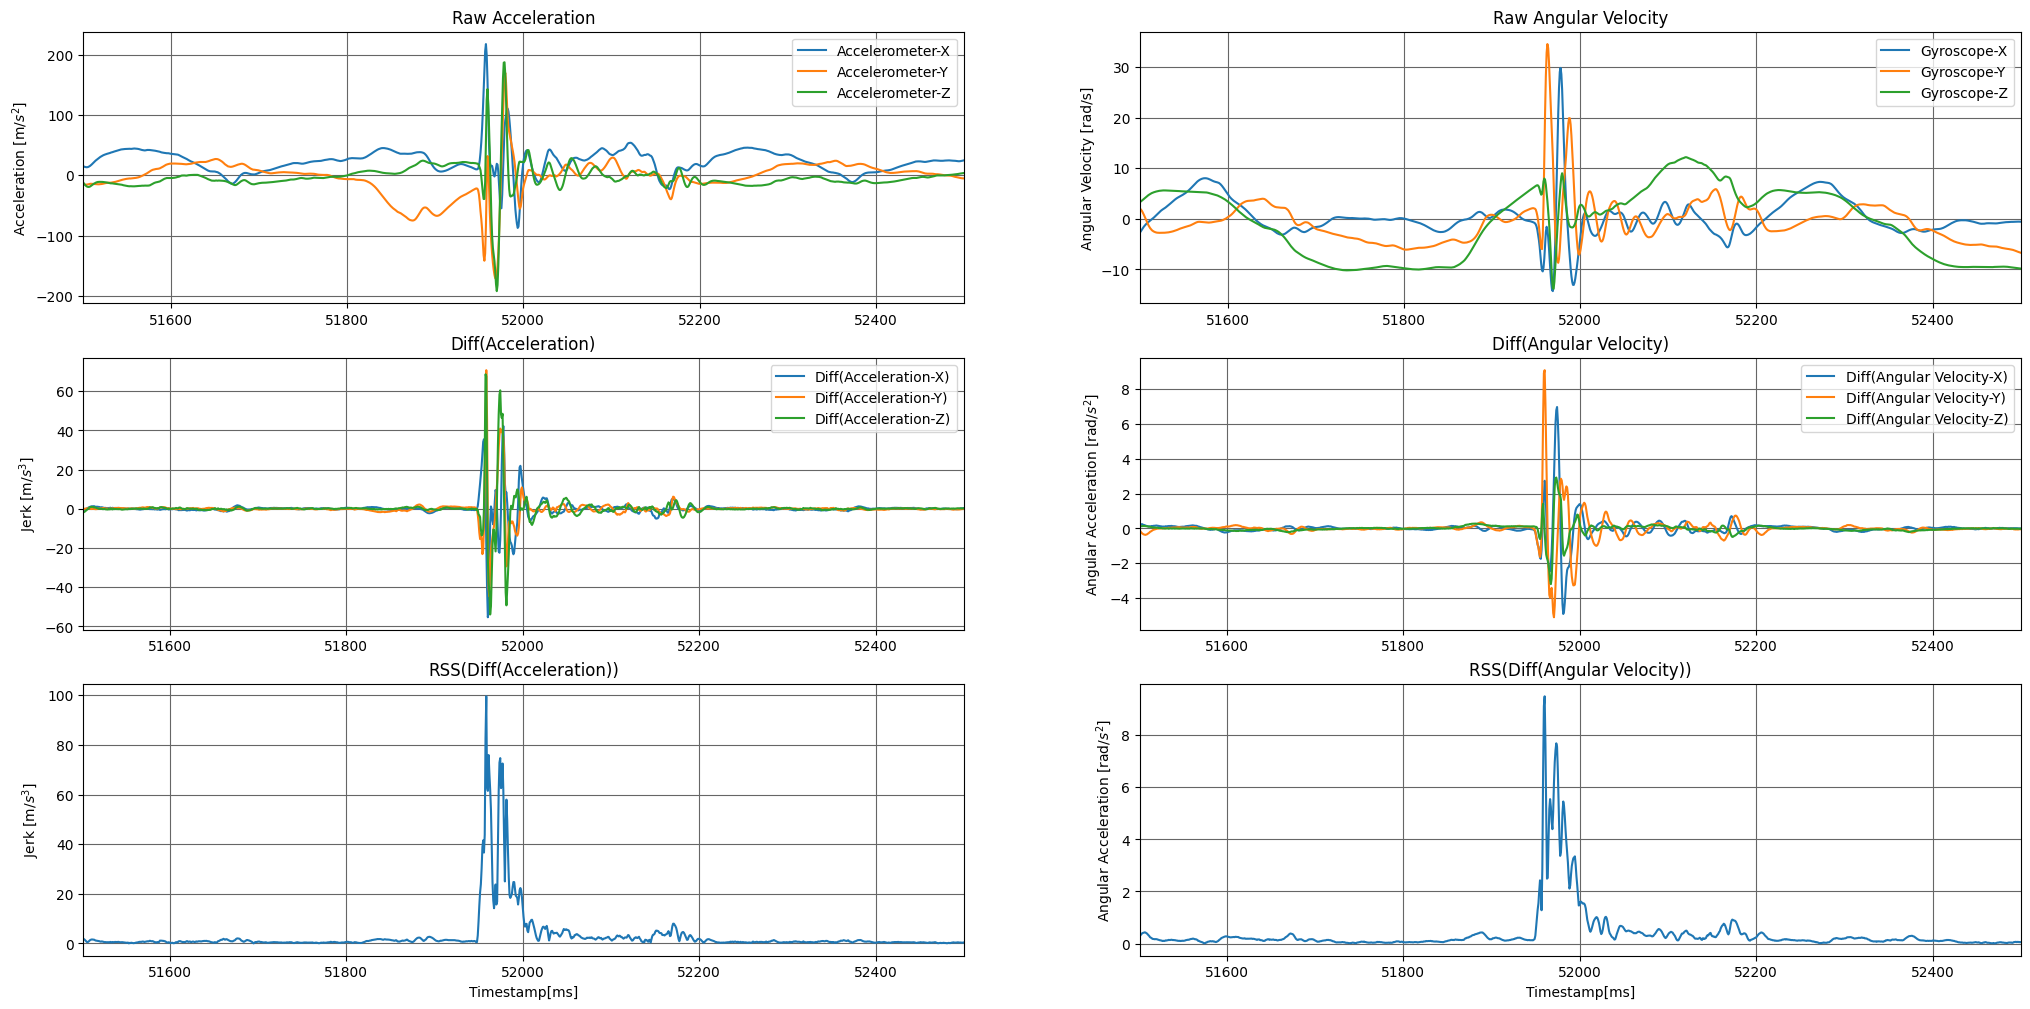

In [91]:
plt.figure(figsize=(25,12))

plt.subplot(321)
plt.title('Raw Acceleration')
plt.ylabel('Acceleration [m/$s^2$]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df_inspect_imu.index, df_inspect_imu['Accel-X'])
plt.plot(df_inspect_imu.index, df_inspect_imu['Accel-Y'])
plt.plot(df_inspect_imu.index, df_inspect_imu['Accel-Z'])
plt.legend(['Accelerometer-X', 'Accelerometer-Y', 'Accelerometer-Z'])
plt.xlim(df_inspect_imu.index[0], df_inspect_imu.index[-1])

plt.subplot(323)
plt.title("Diff(Acceleration)")
plt.ylabel('Jerk [m/$s^3$]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df_inspect_imu.index[1:], np.diff(df_inspect_imu['Accel-X']))
plt.plot(df_inspect_imu.index[1:], np.diff(df_inspect_imu['Accel-Y']))
plt.plot(df_inspect_imu.index[1:], np.diff(df_inspect_imu['Accel-Z']))
plt.legend(['Diff(Acceleration-X)', 'Diff(Acceleration-Y)', 'Diff(Acceleration-Z)'])
plt.xlim(df_inspect_imu.index[1], df_inspect_imu.index[-1])


plt.subplot(322)
plt.title('Raw Angular Velocity')
plt.ylabel('Angular Velocity [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df_inspect_imu.index, df_inspect_imu['Gyro-X'])
plt.plot(df_inspect_imu.index, df_inspect_imu['Gyro-Y'])
plt.plot(df_inspect_imu.index, df_inspect_imu['Gyro-Z'])
plt.legend(['Gyroscope-X', 'Gyroscope-Y', 'Gyroscope-Z'])
plt.xlim(df_inspect_imu.index[0], df_inspect_imu.index[-1])

plt.subplot(324)
plt.title("Diff(Angular Velocity)")
plt.ylabel('Angular Acceleration [rad/$s^2$]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df_inspect_imu.index[1:], np.diff(df_inspect_imu['Gyro-X']))
plt.plot(df_inspect_imu.index[1:], np.diff(df_inspect_imu['Gyro-Y']))
plt.plot(df_inspect_imu.index[1:], np.diff(df_inspect_imu['Gyro-Z']))
plt.legend(['Diff(Angular Velocity-X)', 'Diff(Angular Velocity-Y)', 'Diff(Angular Velocity-Z)'])
plt.xlim(df_inspect_imu.index[1], df_inspect_imu.index[-1])

plt.subplot(325)
plt.title("RSS(Diff(Acceleration))")
plt.ylabel('Jerk [m/$s^3$]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df_inspect_imu.index[1:], np.sqrt(np.diff(df_inspect_imu['Accel-X'])**2+np.diff(df_inspect_imu['Accel-Y'])**2+np.diff(df_inspect_imu['Accel-Z'])**2))
plt.xlim(df_inspect_imu.index[1], df_inspect_imu.index[-1])
plt.xlabel('Timestamp[ms]')

plt.subplot(326)
plt.title("RSS(Diff(Angular Velocity))")
plt.ylabel('Angular Acceleration [rad/$s^2$]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df_inspect_imu.index[1:], np.sqrt(np.diff(df_inspect_imu['Gyro-X'])**2+np.diff(df_inspect_imu['Gyro-Y'])**2+np.diff(df_inspect_imu['Gyro-Z'])**2))
plt.xlim(df_inspect_imu.index[1], df_inspect_imu.index[-1])
plt.xlabel('Timestamp[ms]')

plt.show()

This signal is much better than previous as within the window of a footstrike, there aren't as many high-frequency signals which could lead to false negatives.

## Combine Acc + Gyro into a single 1d signal

In [108]:
df_imu_mag = df_imu.copy()
accel_mag = list(np.sqrt(np.diff(df_imu['Accel-X'])**2+np.diff(df_imu['Accel-Y'])**2+np.diff(df_imu['Accel-Z'])**2))
accel_mag.insert(0, accel_mag[0])
df_imu_mag['Accel'] = accel_mag

gyro_mag = list(np.sqrt(np.diff(df_imu['Gyro-X'])**2+np.diff(df_imu['Gyro-Y'])**2+np.diff(df_imu['Gyro-Z'])**2))
gyro_mag.insert(0, gyro_mag[0])
df_imu_mag['Gyro'] = gyro_mag

df_inspect_imu_mag = df_imu_mag[(df_imu_mag.index > initial_timestamp_to_inspect) & (df_imu_mag.index < final_timestamp_to_inspect)]
df_inspect_imu_mag.head()

Accel-X    Accel-Y    Accel-Z    Gyro-X    Gyro-Y    Gyro-Z  \
Timestamp                                                                  
51500.698  15.160081 -15.121776 -11.712435 -2.705215  2.019865  3.318198   
51501.577  14.489708 -15.428234 -13.532030 -2.471089  1.887904  3.433133   
51502.455  14.001288 -15.552739 -15.217548 -2.234835  1.687833  3.558709   
51503.334  13.656525 -15.514424 -16.673217 -1.994325  1.440937  3.684286   
51504.213  13.464991 -15.389929 -17.812858 -1.753814  1.147215  3.814119   

              Accel      Gyro  
Timestamp                      
51500.698  2.054826  0.259710  
51501.577  1.963222  0.292299  
51502.455  1.759269  0.334087  
51503.334  1.496430  0.366841  
51504.213  1.162310  0.401216

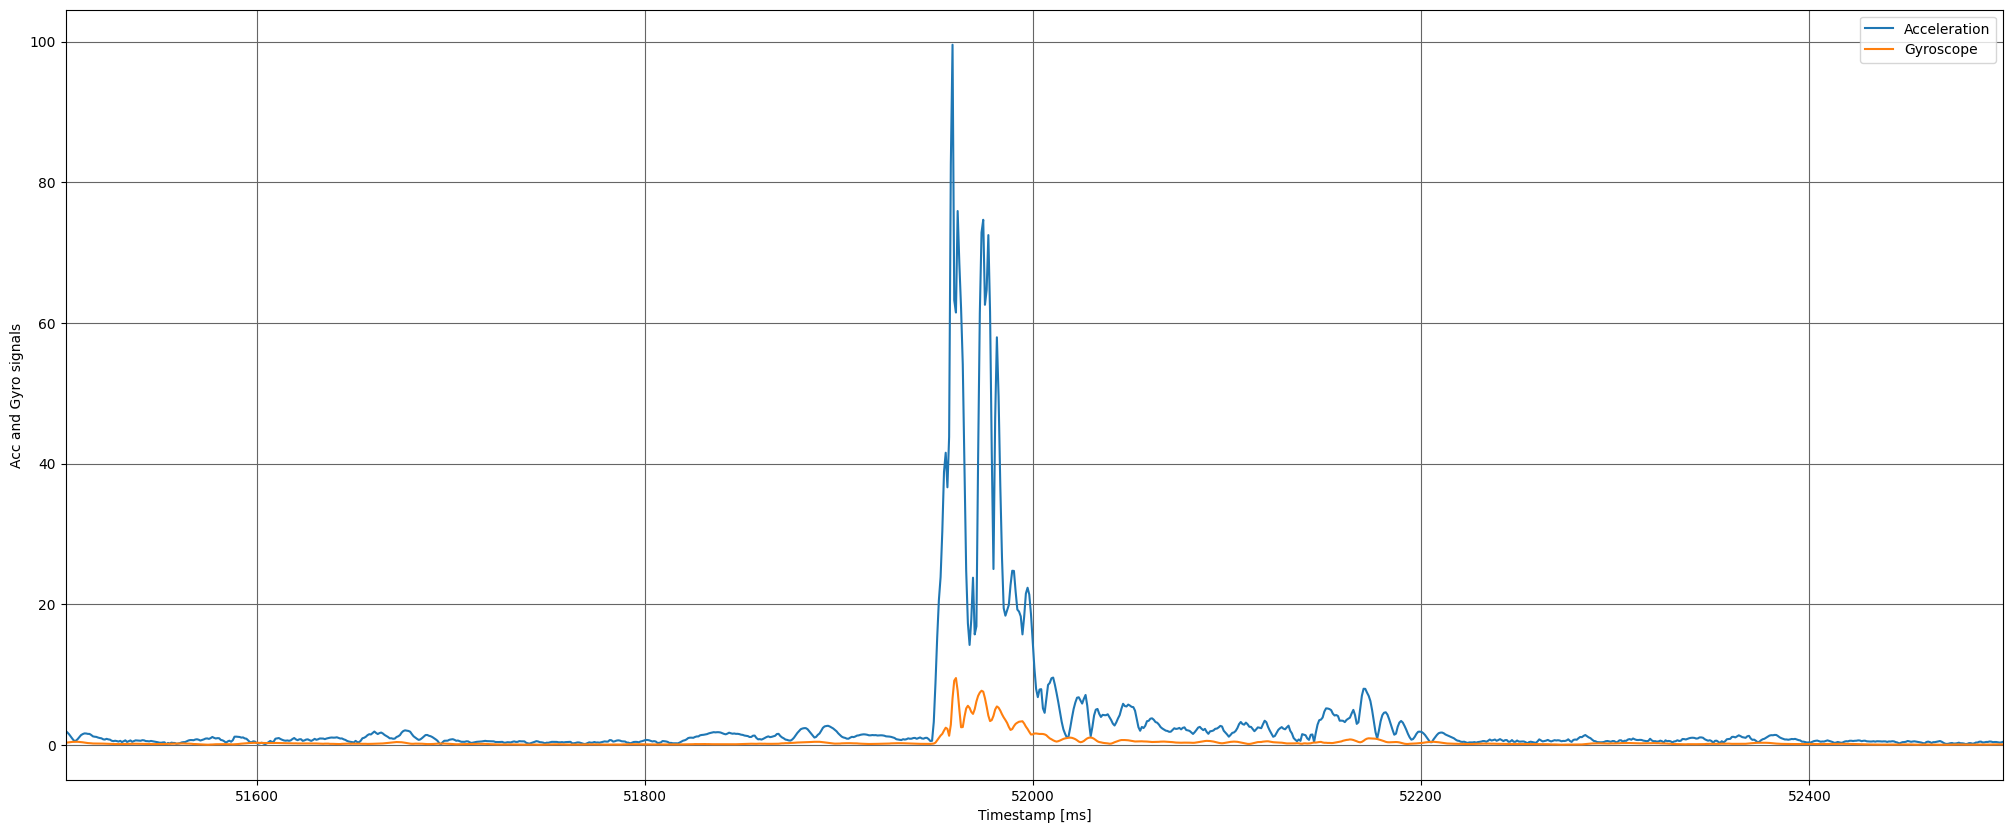

In [112]:
plt.figure(figsize=(25,10))

plt.ylabel('Acc and Gyro signals')
plt.plot(df_inspect_imu_mag.index, df_inspect_imu_mag['Accel'])
plt.plot(df_inspect_imu_mag.index, df_inspect_imu_mag['Gyro'])
plt.legend(["Acceleration", "Gyroscope"])
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlim(df_inspect_imu_mag.index[1], df_inspect_imu_mag.index[-1])
plt.xlabel("Timestamp [ms]")

plt.show()

By looking to the selected features, one may consider dropping the first two. However, these may carry important information, for step detection. So, for now, one will leave them as our selected features.

As it's usual in data science, we should now normalize our selected features, otherwise some features would be more valuable than others. Let's use the Standardizer Scaler, for 2 reasons:
- We don't care about different distorting distances between features, because these aren't related.
- This way we are more robust against outliers
- Also, the mean of these features will be near 0. This means that when applying a rolling average to this data, our cut-off point for step/no-step may be quite clear.

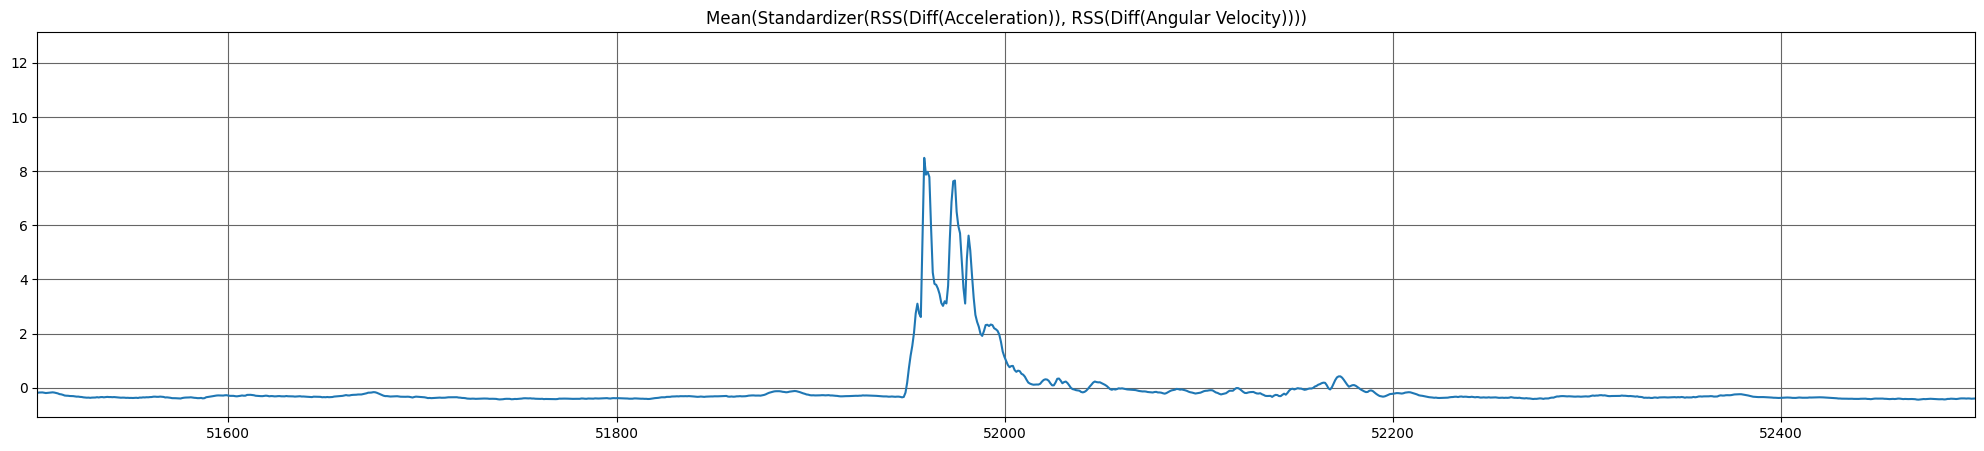

In [117]:
plt.figure(figsize=(25,5))

plt.title('Mean(Standardizer(RSS(Diff(Acceleration)), RSS(Diff(Angular Velocity))))')
std_scaler = preprocessing.StandardScaler()
df_mean_feats = pd.DataFrame(std_scaler.fit_transform(df_imu_mag[['Accel', 'Gyro']].values)).mean(axis=1)
plt.plot(df_imu_mag.index, df_mean_feats)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlim(df_inspect_imu_mag.index[1], df_inspect_imu_mag.index[-1])
plt.show()

Let's now apply convolution, in order to produce a more clear step/no-step signal. Note that by increasing the window of the convolution we will increase the "step window". Thus, such value needs to be kept reasonably low to get the benefits from convolution, while avoid increasing step window time.

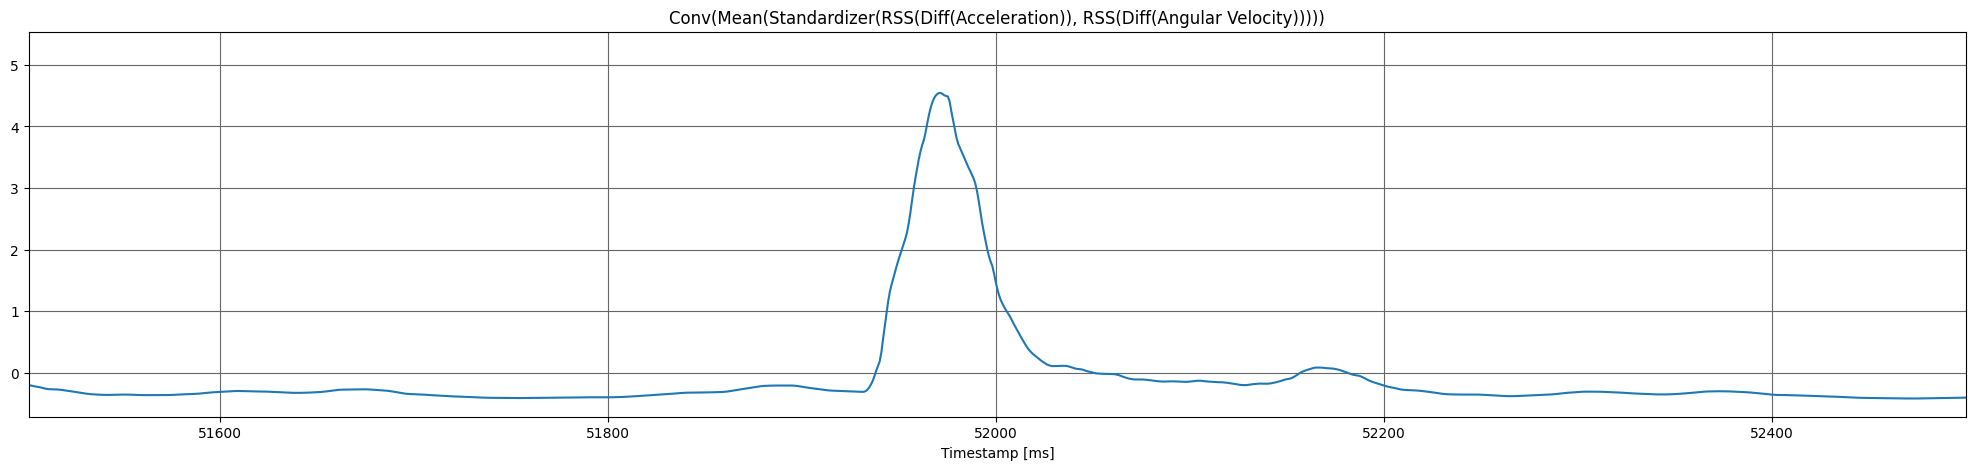

In [126]:
N = 40
df_mean_feats_conv = np.convolve(df_mean_feats.values, np.ones(N)/N, mode='same')

plt.figure(figsize=(25,5))
plt.title('Conv(Mean(Standardizer(RSS(Diff(Acceleration)), RSS(Diff(Angular Velocity)))))')
plt.plot(df_imu_mag.index, df_mean_feats_conv)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlim(df_inspect_imu_mag.index[1], df_inspect_imu_mag.index[-1])
plt.xlabel('Timestamp [ms]')
plt.show()

## Detect a footstrike

Check the signal generated for multiple steps

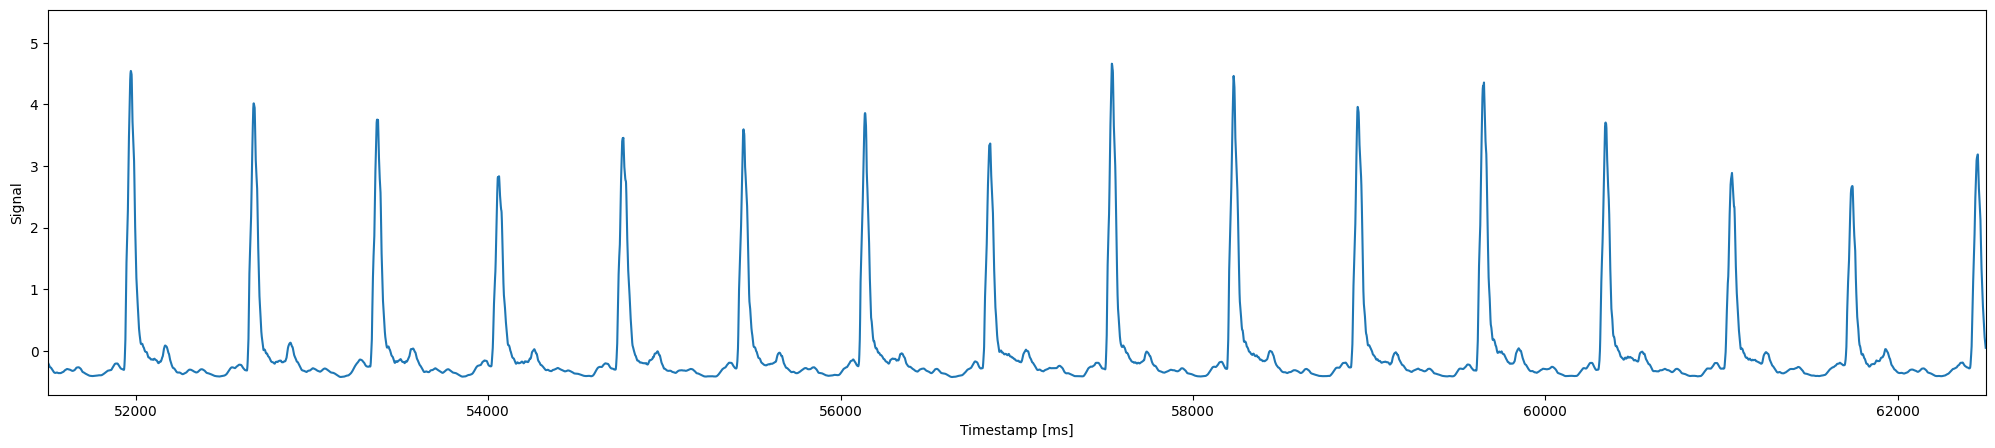

In [132]:
N = 40
df_mean_feats_conv = np.convolve(df_mean_feats.values, np.ones(N)/N, mode='same')

plt.figure(figsize=(25,5))
plt.plot(df_imu_mag.index, df_mean_feats_conv)
plt.xlim(df_imu_mag.index[0], df_imu_mag.index[-1])
# Add timestamp value in order to see multiple steps behaviour
plt.xlim(df_inspect_imu_mag.index[1], df_inspect_imu_mag.index[-1]+10000)
plt.ylabel("Signal")
plt.xlabel("Timestamp [ms]")
plt.show()

Select a threshold in order to detect a step vs no-step

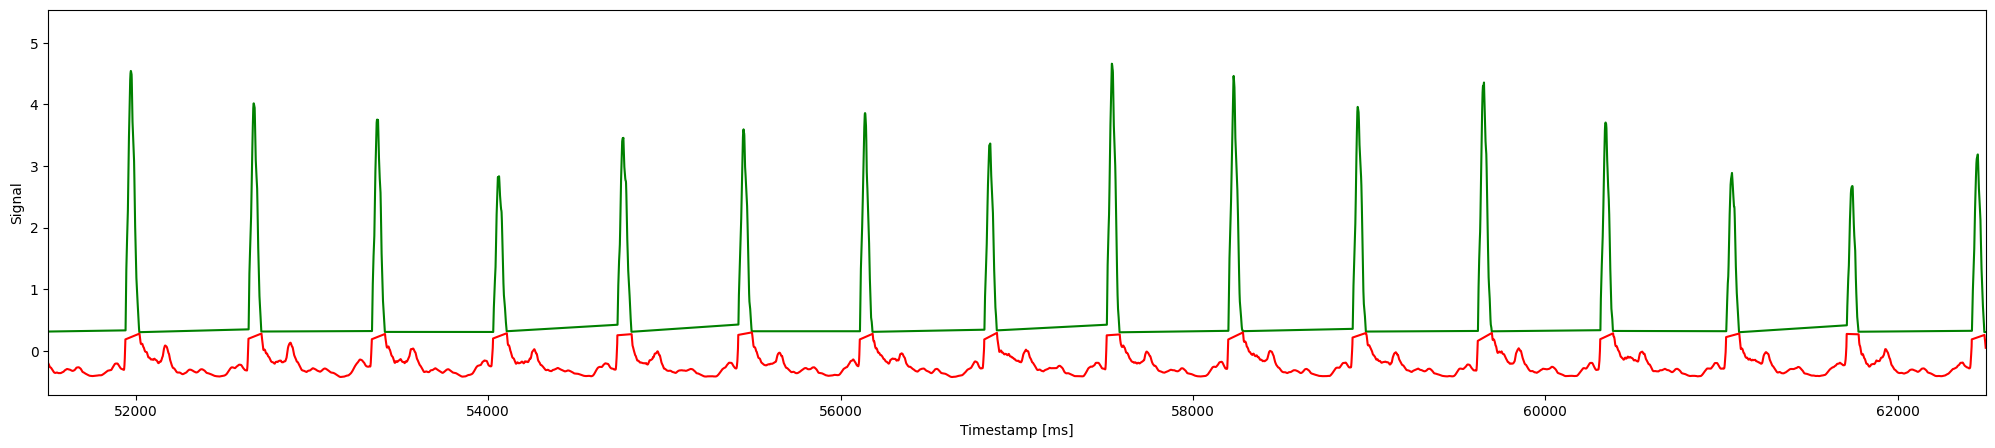

In [135]:
threshold = 0.3

df_step = pd.Series(df_mean_feats_conv).to_frame()
df_step.index = df_imu_mag.index
df_step.columns = ['value']

plt.figure(figsize=(25,5))
plt.plot(df_step[df_step['value']>threshold].index, df_step[df_step['value']>threshold], 'green')
plt.plot(df_step[df_step['value']<threshold].index, df_step[df_step['value']<threshold], 'red')
plt.xlim(df_inspect_imu_mag.index[1], df_inspect_imu_mag.index[-1]+10000)
plt.ylabel("Signal")
plt.xlabel("Timestamp [ms]")
plt.show()

Check whether the threshold + signal is efficient throughout entire run

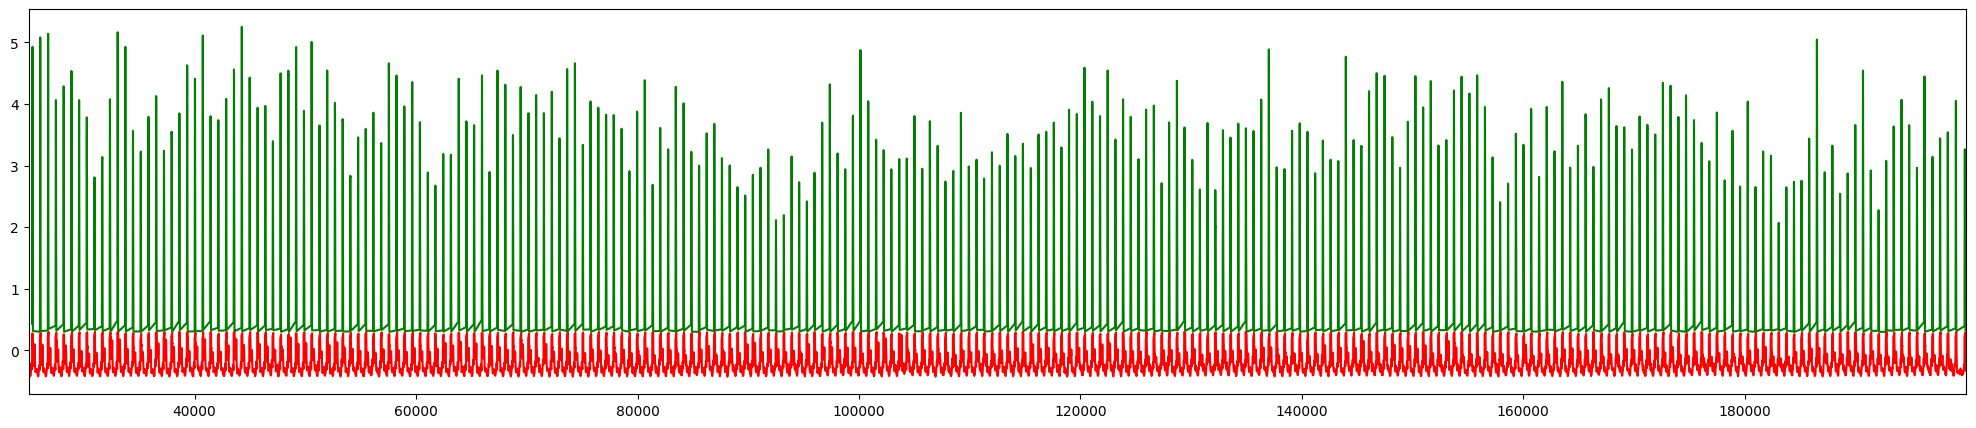

In [136]:
plt.figure(figsize=(25,5))
plt.plot(df_step[df_step['value']>threshold].index, df_step[df_step['value']>threshold], 'green')
plt.plot(df_step[df_step['value']<threshold].index, df_step[df_step['value']<threshold], 'red')
plt.xlim(df_imu_mag.index[0], df_imu_mag.index[-1])
plt.show()

Confirm that there were no steps missed by looking into the time that at which a step was first detected.

- If the samples are concentrated around the average line that's perfect
- If we have an outlier above, means we missed a label
- If we have an outlier below, means we overdetected a label

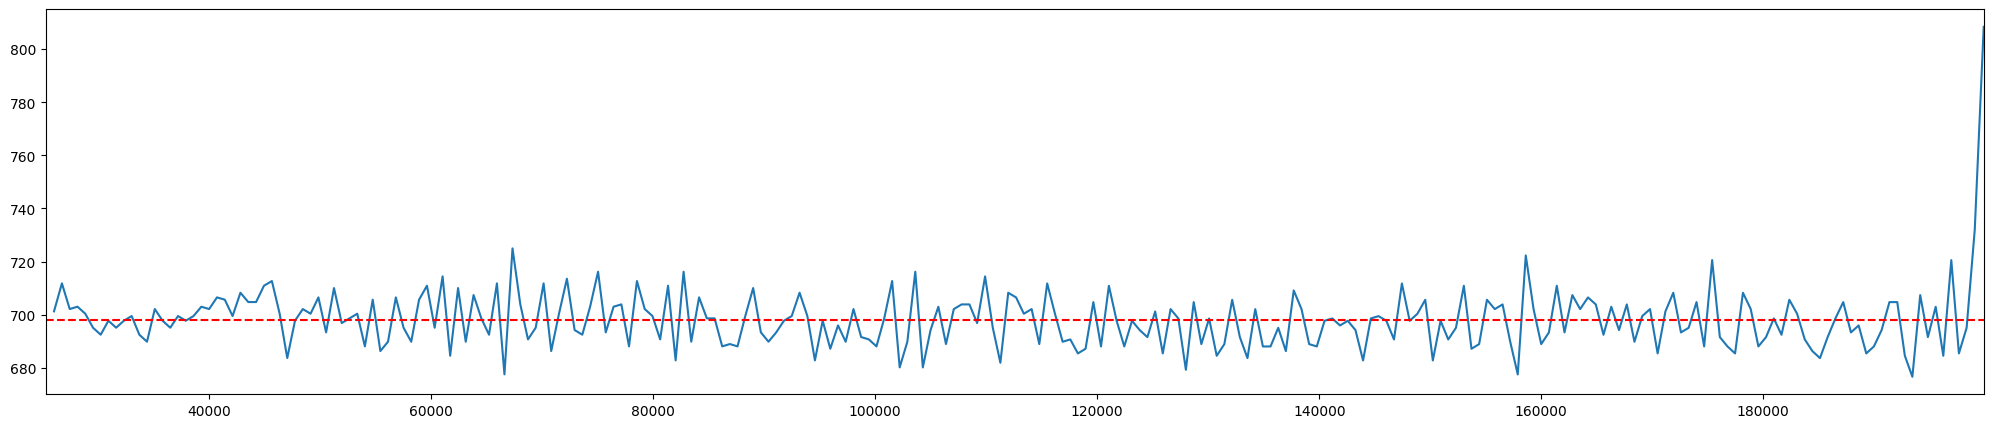

In [140]:
step_detected = list()
rest_detected = list()
is_step = df_step['value'] > threshold

past_val = is_step.values[0]
for i in range(len(is_step)-1):
    if not is_step.values[i] and is_step.values[i+1]:
        step_detected.append(is_step.index[i+1])
    
    if is_step.values[i] and not is_step.values[i+1]:
        rest_detected.append(is_step.index[i+1])
    
plt.figure(figsize=(25,5))
plt.plot(step_detected[1:], np.diff(step_detected))
plt.axhline(np.mean(np.diff(step_detected)), c='red', ls='--')
plt.xlim([step_detected[0], step_detected[-1]])
plt.show()

The code below can be used for further tweaking if necessary

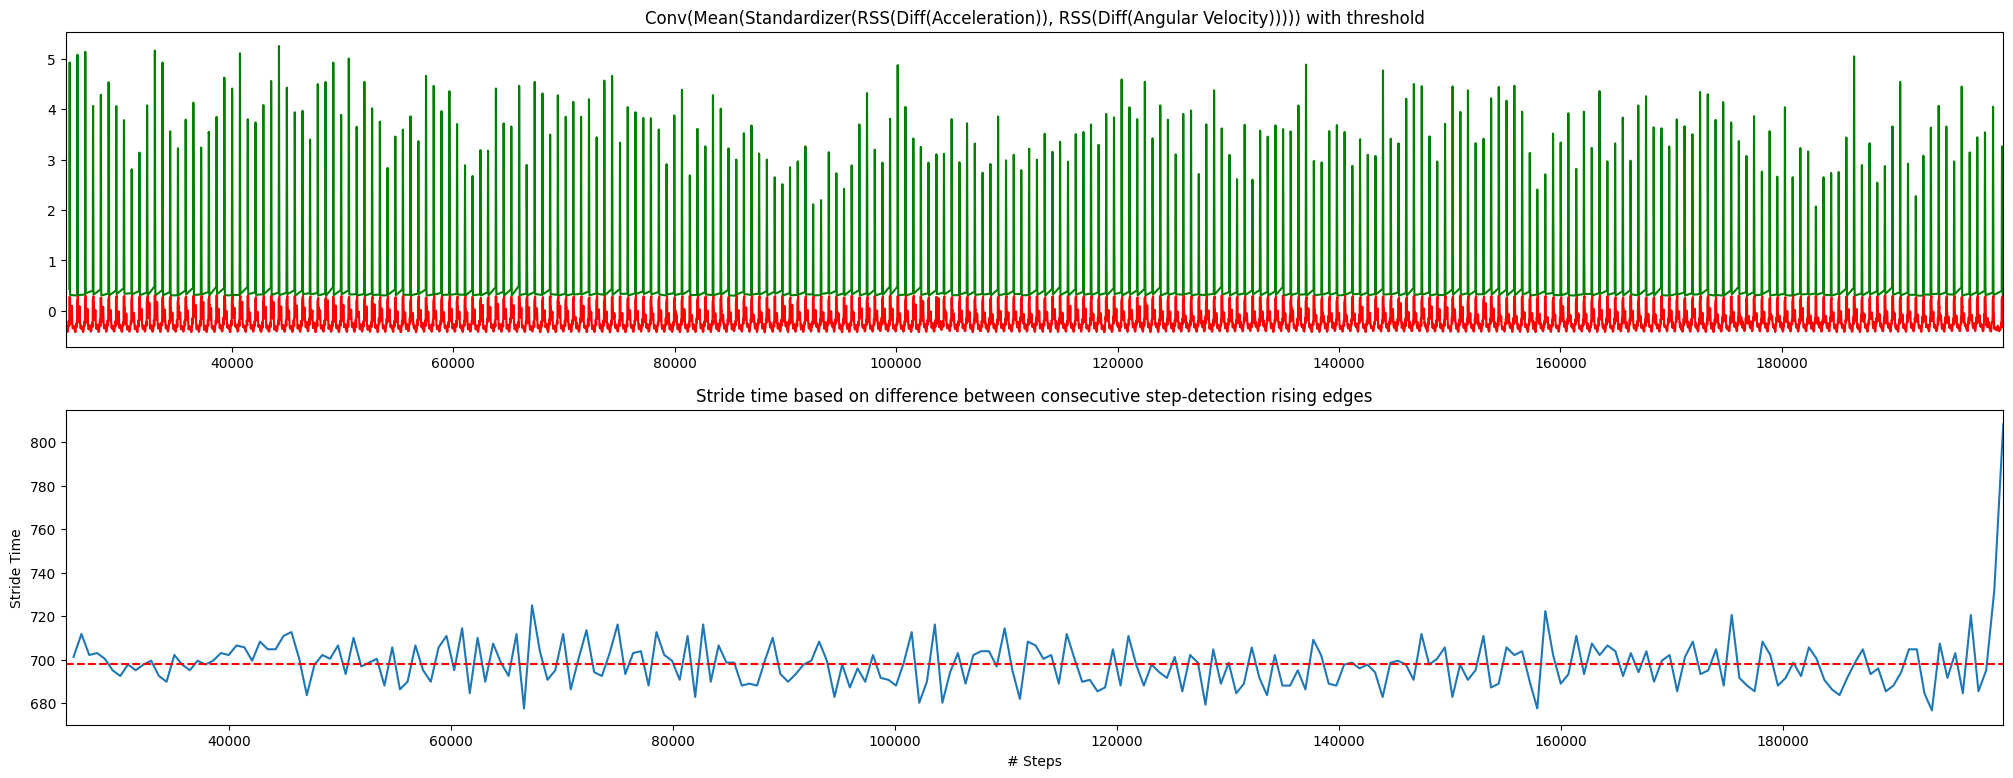

In [142]:
threshold = 0.3
N = 40

df_mean_feats_conv = np.convolve(df_mean_feats.values, np.ones(N)/N, mode='same')
df_step = pd.Series(df_mean_feats_conv).to_frame()
df_step.index = df_imu_mag.index
df_step.columns = ['value']

plt.figure(figsize=(25,9))
plt.subplot(211)
plt.title('Conv(Mean(Standardizer(RSS(Diff(Acceleration)), RSS(Diff(Angular Velocity))))) with threshold')
plt.plot(df_step[df_step['value']>threshold].index, df_step[df_step['value']>threshold], 'green')
plt.plot(df_step[df_step['value']<threshold].index, df_step[df_step['value']<threshold], 'red')
plt.xlim(df_imu_mag.index[0], df_imu_mag.index[-1])

plt.subplot(212)
plt.title('Stride time based on difference between consecutive step-detection rising edges')
plt.plot(step_detected[1:], np.diff(step_detected))
plt.axhline(np.mean(np.diff(step_detected)), c='red', ls='--')
plt.xlim([step_detected[0], step_detected[-1]])
plt.xlabel('# Steps')
plt.ylabel('Stride Time')
plt.show()

Assess IMU samples based on step/no-step label

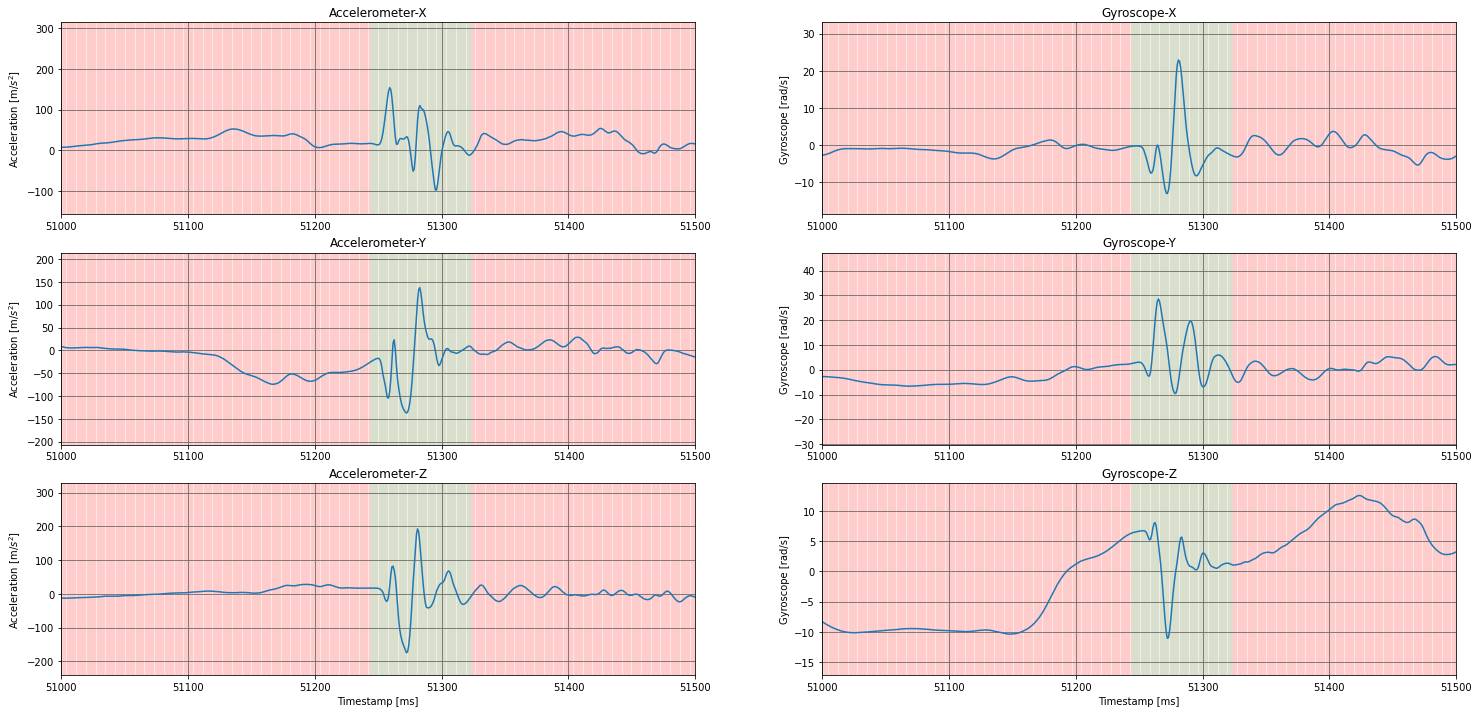

In [170]:
if data_folder == '2019-07-23_CricketPitch_Grant':
    initial_timestamp_to_inspect = 51000
    final_timestamp_to_inspect = 54000
else:
    initial_timestamp_to_inspect = 51000
    final_timestamp_to_inspect = 51500

colors = ['red', 'green']
filter_inspect_time = (is_step.index>initial_timestamp_to_inspect) & (is_step.index < final_timestamp_to_inspect)
    
plt.figure(figsize=(25, 12))

plt.subplot(321)
plt.title('Accelerometer-X')
plt.ylabel('Acceleration [m/$s^2$]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df_imu.index, df_imu['Accel-X'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)
for idx, lbl in enumerate(is_step[filter_inspect_time]):
    plt.gca().axvspan(df_imu[filter_inspect_time].index[idx-1], df_imu[filter_inspect_time].index[idx], alpha=0.05, color=colors[int(lbl)])

plt.subplot(323)
plt.title('Accelerometer-Y')
plt.ylabel('Acceleration [m/$s^2$]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df_imu.index, df_imu['Accel-Y'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)
for idx, lbl in enumerate(is_step[filter_inspect_time]):
    plt.gca().axvspan(df_imu[filter_inspect_time].index[idx-1], df_imu[filter_inspect_time].index[idx], alpha=0.05, color=colors[int(lbl)])

plt.subplot(325)
plt.title('Accelerometer-Z')
plt.ylabel('Acceleration [m/$s^2$]')
plt.xlabel('Timestamp [ms]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df_imu.index, df_imu['Accel-Z'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)
for idx, lbl in enumerate(is_step[filter_inspect_time]):
    plt.gca().axvspan(df_imu[filter_inspect_time].index[idx-1], df_imu[filter_inspect_time].index[idx], alpha=0.05, color=colors[int(lbl)])

plt.subplot(322)
plt.title('Gyroscope-X')
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df_imu.index, df_imu['Gyro-X'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)
for idx, lbl in enumerate(is_step[filter_inspect_time]):
    plt.gca().axvspan(df_imu[filter_inspect_time].index[idx-1], df_imu[filter_inspect_time].index[idx], alpha=0.05, color=colors[int(lbl)])

plt.subplot(324)
plt.title('Gyroscope-Y')
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(df_imu.index, df_imu['Gyro-Y'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)
for idx, lbl in enumerate(is_step[filter_inspect_time]):
    plt.gca().axvspan(df_imu[filter_inspect_time].index[idx-1], df_imu[filter_inspect_time].index[idx], alpha=0.05, color=colors[int(lbl)])

plt.subplot(326)
plt.title('Gyroscope-Z')
plt.ylabel('Gyroscope [rad/s]')
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.xlabel('Timestamp [ms]')
plt.plot(df_imu.index, df_imu['Gyro-Z'])
plt.xlim(initial_timestamp_to_inspect, final_timestamp_to_inspect)
for idx, lbl in enumerate(is_step[filter_inspect_time]):
    plt.gca().axvspan(df_imu[filter_inspect_time].index[idx-1], df_imu[filter_inspect_time].index[idx], alpha=0.05, color=colors[int(lbl)])

plt.show()

# SVM

In [178]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import f1_score

In [155]:
df_imu_label = pd.DataFrame(1*(df_step.values > threshold), columns=['FSD'])
df_imu_label.index = df_imu.index

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_imu[['Accel-X', 'Accel-Y', 'Accel-Z', 'Gyro-X', 'Gyro-Y', 'Gyro-Z']], 
    df_imu_label['FSD'], 
    test_size = 0.20,
    shuffle=False)

In [156]:
# Fast implementation
clf = SVC(kernel='rbf', probability=True, gamma=0.0001, C=1000)

# Search for best model
#grid_params = [{'gamma': [1e-3, 1e-4],
#                'C': [1, 10, 100, 1000]}]
# neg_log_loss is used since we're going to use probabilities in our ensemble model
# this metric means that basically we want better predictions
#clf = GridSearchCV(SVC(kernel='rbf', probability=True), grid_params, scoring='neg_log_loss')
# print(clf.best_params_)

clf.fit(X_train, y_train)

SVC(C=1000, gamma=0.0001, probability=True)

In [187]:
y_pred = clf.predict(X_test)

# This rolling allows to remove spurious samples
# However, we can't use a lot of samples on the MA window otherwise we'll delay the rise edge of the recognition of a step
df_pred = pd.DataFrame(y_pred, columns=['FSD'])
df_pred['FSD'] = np.ceil(df_pred['FSD'].rolling(5, min_periods=1).mean())

print("Confusion Matrix:")
cm = confusion_matrix(y_test.values, df_pred['FSD'].values)
print(cm)

print("\nScores:")
print(classification_report(y_test.values, df_pred['FSD'].values))

print("\nG-Mean:")
print(geometric_mean_score(y_test.values, df_pred['FSD'].values))

Confusion Matrix:
[[35071   382]
 [  211  4166]]

Scores:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     35453
           1       0.92      0.95      0.93      4377

    accuracy                           0.99     39830
   macro avg       0.96      0.97      0.96     39830
weighted avg       0.99      0.99      0.99     39830


G-Mean:
0.970328838251741


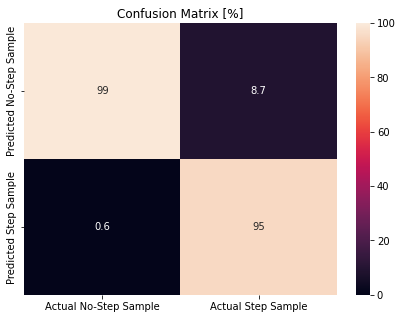

In [171]:
C = confusion_matrix(y_test.values, df_pred['FSD'].values)

df_cm = pd.DataFrame(100*C / C.astype(np.float).sum(axis=1), 
                     index = ['Predicted No-Step Sample', 'Predicted Step Sample'],
                     columns = ['Actual No-Step Sample', 'Actual Step Sample'])
plt.figure(figsize = (7,5))
plt.title('Confusion Matrix [%]')
sns.heatmap(df_cm, vmin=0, vmax=100, annot=True)
plt.show()

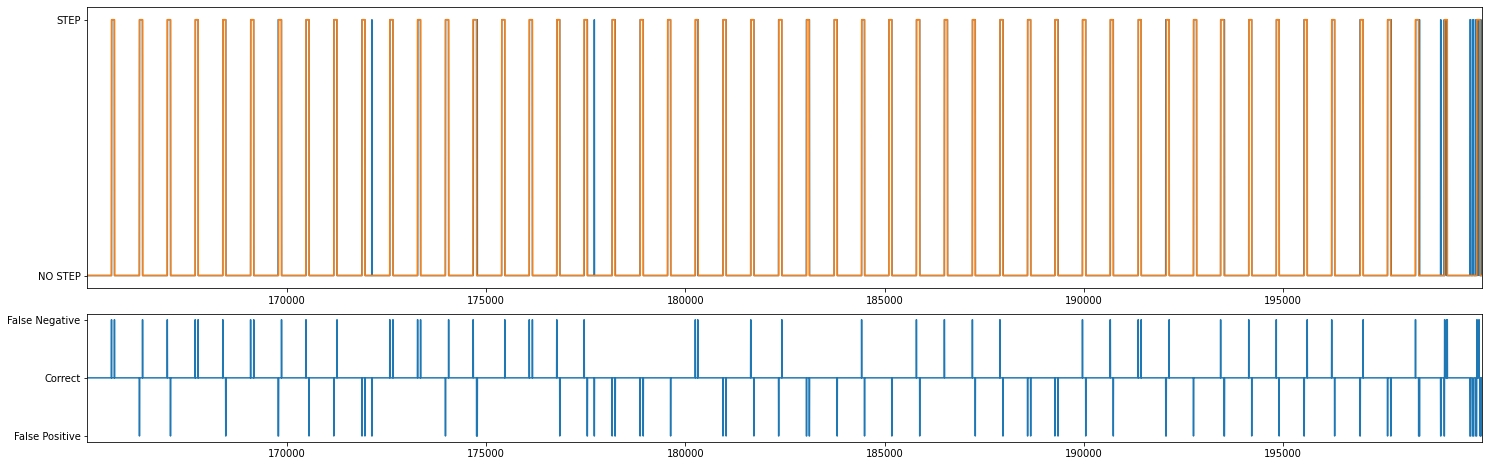

In [173]:
initial_time_insepct = y_test.index[0]
final_time_insepct = y_test.index[-1]

plt.figure(figsize=(25,8))
plt.subplot(3,1,(1,2))
plt.plot(y_test.index, df_pred['FSD'].values)
plt.plot(y_test.index, y_test.values)
plt.xlim([initial_time_insepct, final_time_insepct])
plt.yticks([0, 1], ['NO STEP', 'STEP'])

plt.subplot(3,1,3)
plt.plot(y_test.index, y_test.values-df_pred['FSD'].values)
plt.xlim([initial_time_insepct, final_time_insepct])
plt.yticks([-1, 0, 1], ['False Positive', 'Correct', 'False Negative'])
plt.show()

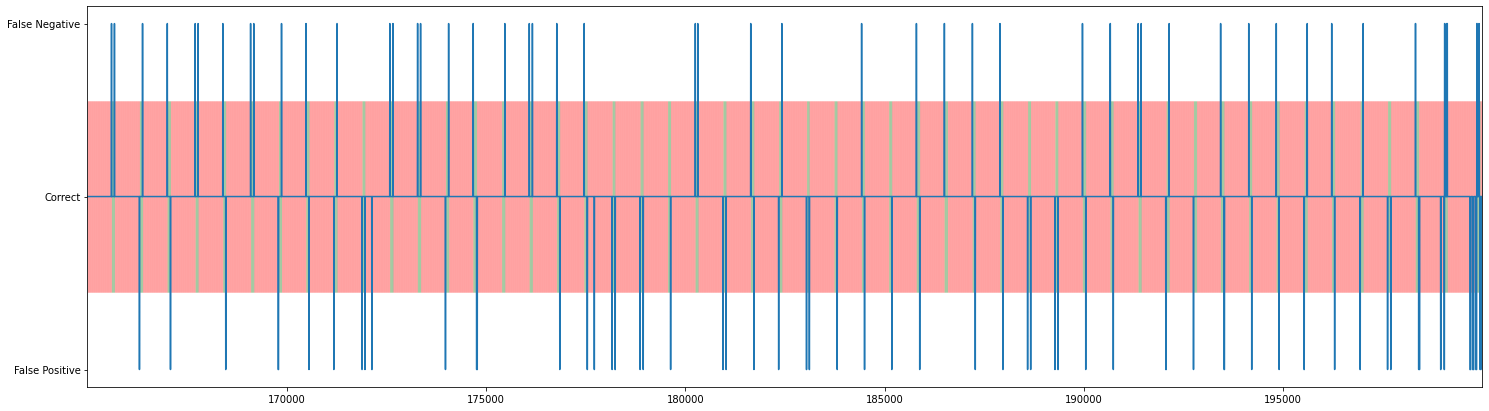

In [182]:
initial_time_insepct = y_test.index[0]
final_time_insepct = y_test.index[-1]

fig, ax = plt.subplots(figsize=(25,7))
colors = ['red', 'green']

plt.plot(y_test.index, y_test.values-df_pred['FSD'].values)
plt.xlim([initial_time_insepct, final_time_insepct])
plt.yticks([-1, 0, 1], ['False Positive', 'Correct', 'False Negative'])
for idx, lbl in enumerate(y_test.values):
    ax.axvspan(y_test.index[idx-1], y_test.index[idx], ymin=.25, ymax=.75, alpha=0.01, color=colors[int(lbl)])

plt.show()

In [ ]:
# Save model
#filename = 'josh_model.sav'
#pickle.dump(clf, open(filename, 'wb'))

## Additional - Extra
Assess PCA with coloring based on signal processing labelling

In [183]:
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    print ('initial decision function shape; ', np.shape(Z))
    Z = Z.reshape(xx.shape)
    print ('after reshape: ', np.shape(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_meshgrid(x, y, h=.1):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h).astype(np.float32),
                         np.arange(y_min, y_max, h).astype(np.float32))
    return xx, yy

In [184]:
df_inspect_imu_mag = df_imu_mag[(df_imu_mag.index > initial_timestamp_to_inspect) & (df_imu_mag.index < final_timestamp_to_inspect)]
df_imu_label = pd.DataFrame(1*(df_step.values > threshold), columns=['FSD'])
df_imu_label_mag = df_imu_label[(df_imu_mag.index > initial_timestamp_to_inspect) & (df_imu_mag.index < final_timestamp_to_inspect)]

C:\Python38\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


initial decision function shape;  (9198774,)
after reshape:  (2069, 4446)


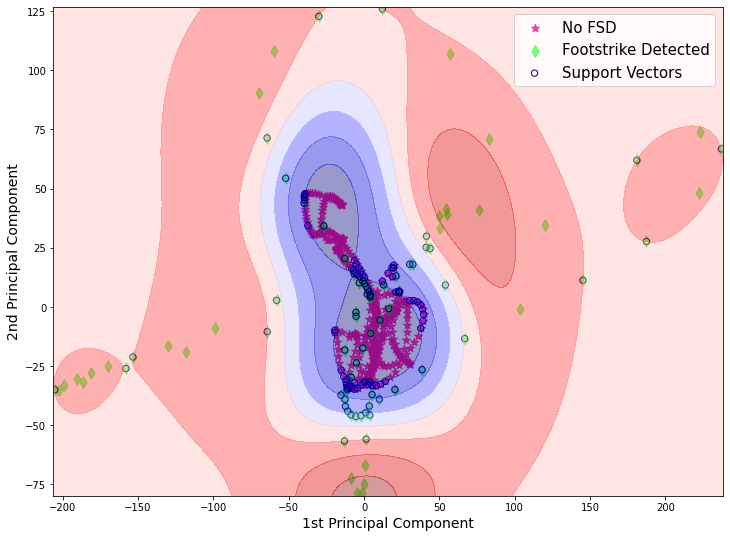

In [185]:
pca2 = PCA(n_components=2)
X_test_reduced = pca2.fit_transform(df_inspect_imu_mag.values)

svm_model = SVC(kernel='rbf')
classify = svm_model.fit(X_test_reduced, df_imu_label_mag.values)

X0, X1 = X_test_reduced[:, 0], X_test_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_facecolor('white')
cdict1={0:'deeppink', 1:'lime'}

#Y_tar_list = pd.Series(df_imu_label_mag.values, df_imu_label_mag.index)
yl1= [int(target1) for target1 in df_imu_label_mag.values]
labels1=yl1
 
labl1={1:'Footstrike Detected',0:'No FSD'}
marker1={0:'*',1:'d'}
alpha1={0:.8, 1:0.5}

for l1 in np.unique(labels1):
    ix1=np.where(labels1==l1)
    ax.scatter(X0[ix1],X1[ix1], c=cdict1[l1],label=labl1[l1],s=70,marker=marker1[l1],alpha=alpha1[l1])

ax.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1], s=40, facecolors='none', 
           edgecolors='navy', label='Support Vectors')

plot_contours(ax, classify, xx, yy,cmap='seismic', alpha=0.4)
plt.legend(fontsize=15)

plt.xlabel("1st Principal Component",fontsize=14)
plt.ylabel("2nd Principal Component",fontsize=14)

plt.show()